## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd
from scipy.integrate import trapz, cumtrapz

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
    ]

In [3]:
the_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])
raw_times, raw_cumdata, H, cH, D, G = the_data.iloc[:,1:].values.T

In [4]:
start = 0
clip = None
times = raw_times[start:(-clip if clip else None)] + 33
cumdata = raw_cumdata[start:(-clip if clip else None)]

Text(0.5, 0, 'Days after 28 August 2019')

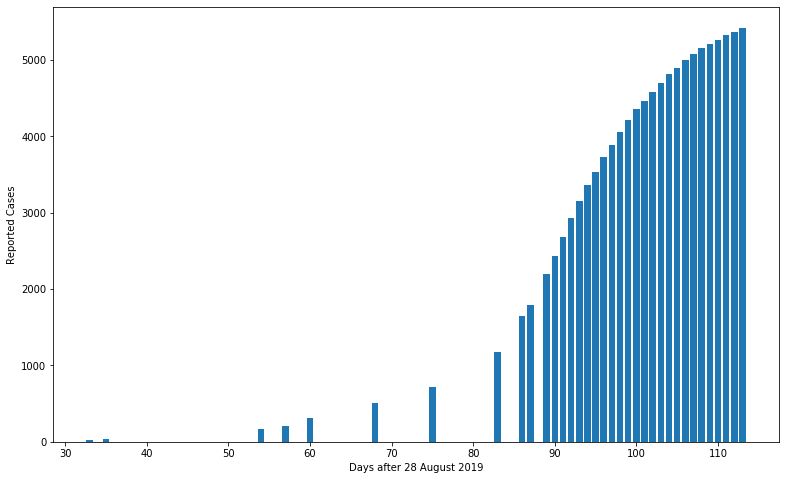

In [5]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

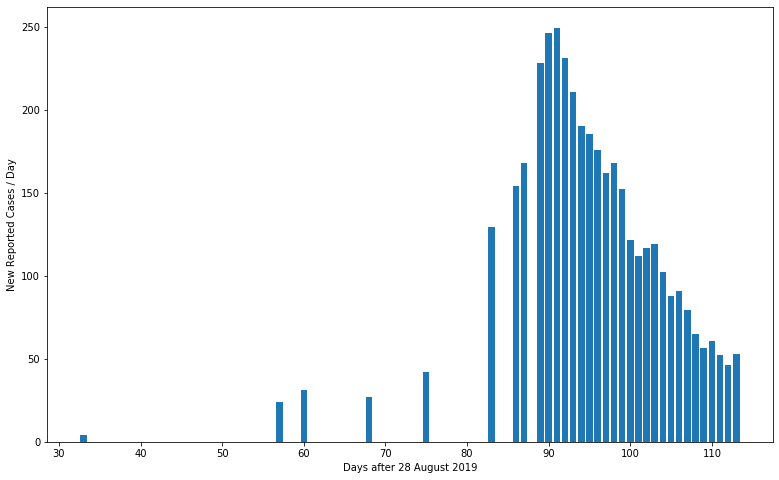

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [7]:
def cumE(t, p, e):
    dt = ca.diff(t)
    xm = (e[:-1]+e[1:])/2
    return p[2]*ca.vcat([0, ca.cumsum(xm*dt)])

In [8]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 120,
    "basis_number": 48,
    "model_form": {
        "state": 4,
        "parameters": 3
    },
    "time_span": [times[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_model": [cumE],
    "observation_vector": [[1]],
    "weightings":[
        [1]*4,
        np.sqrt((times+1)/np.mean(times+1))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getc = ca.Function('getx', [solver_setup['x']], model.cs)
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [11]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(4)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*4) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [12]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1720
Number of nonzeros in Lagrangian Hessian.............:     3717

Total number of variables............................:      195
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

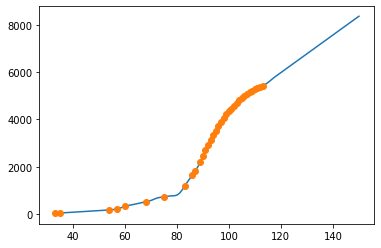

In [13]:
pure_cs = getc(pure_solve['x'])
pure_xs = getx(pure_solve['x'])
pure_ps = getp(pure_solve['x'])
plt.plot(model.observation_times, pure_ps[2]*cumtrapz(pure_xs[1].toarray().flatten(),model.observation_times, initial=0))
plt.plot(times, cumdata, 'o')

In [14]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [15]:
prange = np.logspace(-6, 5, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1720
Number of nonzeros in Lagrangian Hessian.............:     3717

Total number of variables............................:      195
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      480
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 510  4.0475003e+01 0.00e+00 2.07e+04  -2.5 6.09e+01    -  1.00e+00 1.00e+00f  1
 520  4.0422882e+01 0.00e+00 5.25e+03  -2.5 2.99e+01    -  1.00e+00 1.00e+00f  1
 530  4.0375359e+01 0.00e+00 2.20e+04  -2.5 2.27e+02    -  1.00e+00 2.50e-01f  3
 540  4.0326793e+01 0.00e+00 5.94e+03  -2.5 3.10e+01    -  1.00e+00 1.00e+00f  1
 550  4.0282504e+01 0.00e+00 9.16e+03  -2.5 3.81e+01    -  1.00e+00 1.00e+00f  1
 560  4.0240278e+01 0.00e+00 2.76e+04  -2.5 2.52e+02    -  1.00e+00 2.50e-01f  3
 570  4.0199681e+01 0.00e+00 2.80e+04  -2.5 6.50e+01    -  1.00e+00 1.00e+00f  1
 580  4.0160030e+01 0.00e+00 2.02e+04  -2.5 5.45e+01    -  1.00e+00 1.00e+00f  1
 590  4.0123761e+01 0.00e+00 1.25e+04  -2.5 7.09e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  4.0088258e+01 0.00e+00 2.52e+04  -2.5 5.94e+01    -  1.00e+00 1.00e+00f  1
 610  4.0054053e+01 0.00e+00 2.09e+04  -2.5 5.34e+01    -  1.00e+00 1.00e+00f  1
 620  4.0020610e+01 0.00e+00

1480  3.8702780e+01 0.00e+00 1.25e+02  -2.5 1.94e+00    -  1.00e+00 1.00e+00f  1
1490  3.8696277e+01 0.00e+00 3.77e+02  -2.5 3.39e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8690221e+01 0.00e+00 6.47e+02  -2.5 7.66e+00    -  1.00e+00 5.00e-01f  2
1510  3.8684238e+01 0.00e+00 1.11e+03  -2.5 1.12e+01    -  1.00e+00 5.00e-01f  2
1520  3.8678967e+01 0.00e+00 6.00e+02  -2.5 7.63e+00    -  1.00e+00 5.00e-01f  2
1530  3.8674009e+01 0.00e+00 3.67e+02  -2.5 3.40e+00    -  1.00e+00 1.00e+00f  1
1540  3.8669481e+01 0.00e+00 3.88e+02  -2.5 3.51e+00    -  1.00e+00 1.00e+00f  1
1550  3.8665256e+01 0.00e+00 3.84e+02  -2.5 1.26e+01    -  1.00e+00 2.50e-01f  3
1560  3.8661359e+01 0.00e+00 6.16e+02  -2.5 8.42e+00    -  1.00e+00 5.00e-01f  2
1570  3.8658062e+01 0.00e+00 1.70e+02  -2.5 2.33e+00    -  1.00e+00 1.00e+00f  1
1580  3.8654973e+01 0.00e+00 4.98e+01  -2.5 1.26e+00    -  1.00e+00 1.00e+00f  1
1590  3.8652383e+01 0.00e+00

 310  4.2171116e+01 0.00e+00 1.85e+04  -1.0 5.60e+01    -  1.00e+00 1.00e+00f  1
 320  4.2212918e+01 0.00e+00 2.52e+04  -1.0 6.31e+01    -  1.00e+00 1.00e+00f  1
 330  4.2248727e+01 0.00e+00 1.33e+04  -1.0 4.43e+01    -  1.00e+00 1.00e+00f  1
 340  4.2291693e+01 0.00e+00 1.19e+04  -1.0 4.02e+01    -  1.00e+00 1.00e+00f  1
 350  4.2336741e+01 0.00e+00 8.84e+03  -1.0 3.33e+01    -  1.00e+00 1.00e+00f  1
 360  4.2392672e+01 0.00e+00 3.42e+04  -1.0 6.37e+01    -  1.00e+00 1.00e+00f  1
 370  4.2435160e+01 0.00e+00 8.48e+03  -1.0 3.31e+01    -  1.00e+00 1.00e+00f  1
 380  4.2493231e+01 0.00e+00 2.83e+04  -1.0 6.09e+01    -  1.00e+00 1.00e+00f  1
 390  4.2551052e+01 0.00e+00 3.09e+04  -1.0 4.71e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.2606898e+01 0.00e+00 1.53e+04  -1.0 4.74e+01    -  1.00e+00 1.00e+00f  1
 410  4.2679772e+01 0.00e+00 4.42e+04  -1.0 8.14e+01    -  1.00e+00 1.00e+00f  1
 420  4.2769160e+01 0.00e+00

1300  3.9537465e+01 0.00e+00 5.00e+03  -2.5 1.98e+01    -  1.00e+00 1.00e+00f  1
1310  3.9517838e+01 0.00e+00 2.59e+03  -2.5 1.40e+01    -  1.00e+00 1.00e+00f  1
1320  3.9498739e+01 0.00e+00 1.91e+03  -2.5 1.19e+01    -  1.00e+00 1.00e+00f  1
1330  3.9480781e+01 0.00e+00 3.18e+03  -2.5 1.52e+01    -  1.00e+00 1.00e+00f  1
1340  3.9462862e+01 0.00e+00 3.47e+03  -2.5 5.32e+01    -  1.00e+00 2.50e-01f  3
1350  3.9444643e+01 0.00e+00 3.01e+03  -2.5 1.45e+01    -  1.00e+00 1.00e+00f  1
1360  3.9427422e+01 0.00e+00 8.56e+03  -2.5 2.44e+01    -  1.00e+00 1.00e+00f  1
1370  3.9410008e+01 0.00e+00 3.58e+03  -2.5 1.56e+01    -  1.00e+00 1.00e+00f  1
1380  3.9392689e+01 0.00e+00 6.43e+03  -2.5 2.07e+01    -  1.00e+00 1.00e+00f  1
1390  3.9375631e+01 0.00e+00 3.21e+03  -2.5 4.99e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  3.9358286e+01 0.00e+00 6.43e+02  -2.5 6.33e+00    -  1.00e+00 1.00e+00f  1
1410  3.9341734e+01 0.00e+00

2250  3.8409450e+01 0.00e+00 5.33e+00  -5.7 1.52e+03 -12.8 1.00e+00 1.00e+00f  1
2260  3.8405620e+01 0.00e+00 5.76e-01  -5.7 1.66e+04    -  1.42e-01 1.00e+00f  1
2270  3.8404034e+01 0.00e+00 2.46e+01  -5.7 2.55e+03 -12.6 1.00e+00 1.00e+00f  1
2280  3.8376340e+01 0.00e+00 6.24e-01  -5.7 2.42e+03 -13.2 1.00e+00 1.00e+00f  1
2290  3.8376255e+01 0.00e+00 1.07e-01  -5.7 9.21e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  3.8376125e+01 0.00e+00 1.06e-08  -8.6 2.95e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 2303

                                   (scaled)                 (unscaled)
Objective...............:   3.8376125401362145e+01    3.8376125401362145e+01
Dual infeasibility......:   7.7501911006883893e-09    7.7501911006883893e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0918516779851198e-10    9.0918516779851198e-10
Overall NLP error....

 600  4.5411839e+01 0.00e+00 8.73e+03  -1.0 5.41e+01    -  1.00e+00 1.00e+00f  1
 610  4.5595467e+01 0.00e+00 5.07e+04  -1.0 1.30e+02    -  1.00e+00 1.00e+00f  1
 620  4.5782534e+01 0.00e+00 5.52e+04  -1.0 2.52e+02    -  1.00e+00 5.00e-01f  2
 630  4.5958740e+01 0.00e+00 4.21e+04  -1.0 4.51e+02    -  1.00e+00 2.50e-01f  3
 640  4.6129693e+01 0.00e+00 1.90e+04  -1.0 8.31e+01    -  1.00e+00 1.00e+00f  1
 650  4.6292187e+01 0.00e+00 2.53e+04  -1.0 1.64e+02    -  1.00e+00 5.00e-01f  2
 660  4.6454628e+01 0.00e+00 4.98e+04  -1.0 1.37e+02    -  1.00e+00 1.00e+00f  1
 670  4.6574318e+01 0.00e+00 1.21e+04  -1.0 6.81e+01    -  1.00e+00 1.00e+00f  1
 680  4.6676291e+01 0.00e+00 9.06e+03  -1.0 1.14e+02    -  1.00e+00 5.00e-01f  2
 690  4.6691807e+01 0.00e+00 2.81e+05  -2.5 2.13e+04    -  6.79e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  4.4947862e+01 0.00e+00 1.24e+05  -2.5 8.65e+03    -  1.00e+00 1.00e+00f  1
 710  4.4488870e+01 0.00e+00

1580  3.8966534e+01 0.00e+00 8.56e+02  -2.5 5.67e+00    -  1.00e+00 1.00e+00f  1
1590  3.8953061e+01 0.00e+00 2.36e+03  -2.5 9.36e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  3.8939608e+01 0.00e+00 3.67e+03  -2.5 2.22e+01    -  1.00e+00 5.00e-01f  2
1610  3.8926060e+01 0.00e+00 2.53e+03  -2.5 3.60e+01    -  1.00e+00 2.50e-01f  3
1620  3.8912932e+01 0.00e+00 2.20e+03  -2.5 8.80e+00    -  1.00e+00 1.00e+00f  1
1630  3.8900128e+01 0.00e+00 3.55e+03  -2.5 1.11e+01    -  1.00e+00 1.00e+00f  1
1640  3.8887146e+01 0.00e+00 7.66e+02  -2.5 5.08e+00    -  1.00e+00 1.00e+00f  1
1650  3.8874592e+01 0.00e+00 2.46e+03  -2.5 9.06e+00    -  1.00e+00 1.00e+00f  1
1660  3.8862464e+01 0.00e+00 2.53e+03  -2.5 9.11e+00    -  1.00e+00 1.00e+00f  1
1670  3.8850622e+01 0.00e+00 1.17e+03  -2.5 6.12e+00    -  1.00e+00 1.00e+00f  1
1680  3.8838709e+01 0.00e+00 1.81e+03  -2.5 7.56e+00    -  1.00e+00 1.00e+00f  1
1690  3.8827496e+01 0.00e+00

  30  4.1435597e+01 0.00e+00 1.17e+04  -1.0 2.39e+02    -  1.00e+00 2.50e-01f  3
  40  4.1447594e+01 0.00e+00 1.12e+04  -1.0 6.22e+01    -  1.00e+00 1.00e+00f  1
  50  4.1463254e+01 0.00e+00 1.05e+04  -1.0 5.96e+01    -  1.00e+00 1.00e+00f  1
  60  4.1490912e+01 0.00e+00 1.25e+04  -1.0 6.39e+01    -  1.00e+00 1.00e+00f  1
  70  4.1508525e+01 0.00e+00 1.06e+04  -1.0 5.87e+01    -  1.00e+00 1.00e+00f  1
  80  4.1538281e+01 0.00e+00 1.20e+04  -1.0 2.22e+02    -  1.00e+00 2.50e-01f  3
  90  4.1592416e+01 0.00e+00 2.00e+04  -1.0 2.98e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1591305e+01 0.00e+00 1.06e+04  -1.0 5.61e+01    -  1.00e+00 1.00e+00f  1
 110  4.1615414e+01 0.00e+00 5.67e+03  -1.0 4.05e+01    -  1.00e+00 1.00e+00f  1
 120  4.1646995e+01 0.00e+00 5.10e+03  -1.0 3.80e+01    -  1.00e+00 1.00e+00f  1
 130  4.1695564e+01 0.00e+00 1.60e+04  -1.0 6.65e+01    -  1.00e+00 1.00e+00f  1
 140  4.1746181e+01 0.00e+00

1000  4.1868291e+01 0.00e+00 1.21e+03  -1.7 1.28e+01    -  1.00e+00 1.00e+00f  1
1010  4.1835638e+01 0.00e+00 8.77e+03  -1.7 1.35e+02    -  1.00e+00 2.50e-01f  3
1020  4.1808288e+01 0.00e+00 1.30e+03  -1.7 1.31e+01    -  1.00e+00 1.00e+00f  1
1030  4.1781877e+01 0.00e+00 3.42e+03  -1.7 7.88e+01    -  1.00e+00 2.50e-01f  3
1040  4.1757917e+01 0.00e+00 3.14e+03  -1.7 3.68e+01    -  1.00e+00 5.00e-01f  2
1050  4.1736192e+01 0.00e+00 2.28e+03  -1.7 3.03e+01    -  1.00e+00 5.00e-01f  2
1060  4.1716646e+01 0.00e+00 7.20e+02  -1.7 9.55e+00    -  1.00e+00 1.00e+00f  1
1070  4.1699533e+01 0.00e+00 1.41e+03  -1.7 2.38e+01    -  1.00e+00 5.00e-01h  2
1080  4.1684212e+01 0.00e+00 1.53e+03  -1.7 1.39e+01    -  1.00e+00 1.00e+00h  1
1090  4.1672997e+01 0.00e+00 1.54e+02  -1.7 4.36e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  4.1665222e+01 0.00e+00 5.57e-01  -1.7 2.61e-01    -  1.00e+00 1.00e+00h  1
1110  4.1009639e+01 0.00e+00

1990  3.8447393e+01 0.00e+00 1.79e+02  -5.7 1.22e+03 -11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.8443431e+01 0.00e+00 3.05e+00  -5.7 1.69e+03 -12.5 1.00e+00 1.00e+00f  1
2010  3.8439564e+01 0.00e+00 5.35e-02  -5.7 9.44e+02 -11.0 1.00e+00 1.00e+00f  1
2020  3.8434860e+01 0.00e+00 5.61e+01  -5.7 1.60e+04 -13.0 1.00e+00 5.00e-01f  2
2030  3.8430785e+01 0.00e+00 1.77e+02  -5.7 1.07e+05 -13.3 5.99e-01 3.11e-02f  3
2040  3.8424763e+01 0.00e+00 4.60e+01  -5.7 3.88e+04 -14.4 2.92e-03 3.19e-02f  1
2050  3.8424618e+01 0.00e+00 1.44e-02  -8.6 1.34e+02    -  1.00e+00 9.61e-01f  1
2060  3.8424616e+01 0.00e+00 3.32e-06  -9.0 5.69e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 2062

                                   (scaled)                 (unscaled)
Objective...............:   3.8424615850346115e+01    3.8424615850346115e+01
Dual infeasibility......:   1.1478694652264127e-09    1.1478694652264127e-09
Constraint vi

 620  4.6863652e+01 0.00e+00 6.90e+02  -1.0 1.46e+01    -  1.00e+00 1.00e+00f  1
 630  4.6925631e+01 0.00e+00 1.60e+01  -1.0 2.23e+00    -  1.00e+00 1.00e+00h  1
 640  4.5317843e+01 0.00e+00 8.49e+04  -2.5 3.99e+03    -  1.00e+00 1.00e+00f  1
 650  4.4886035e+01 0.00e+00 4.87e+04  -2.5 1.18e+02  -6.9 1.00e+00 1.00e+00f  1
 660  4.4445987e+01 0.00e+00 2.26e+04  -2.5 7.46e+03 -11.6 1.00e+00 1.00e+00f  1
 670  4.3714167e+01 0.00e+00 1.75e+05  -2.5 2.17e+02    -  1.00e+00 1.00e+00f  1
 680  4.3411451e+01 0.00e+00 1.05e+05  -2.5 1.64e+02    -  1.00e+00 1.00e+00f  1
 690  4.3157937e+01 0.00e+00 8.03e+04  -2.5 5.28e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  4.2927400e+01 0.00e+00 6.26e+04  -2.5 4.47e+02    -  1.00e+00 2.50e-01f  3
 710  4.2711259e+01 0.00e+00 1.89e+04  -2.5 6.49e+01    -  1.00e+00 1.00e+00f  1
 720  4.2526176e+01 0.00e+00 8.98e+04  -2.5 1.40e+02    -  1.00e+00 1.00e+00f  1
 730  4.2340540e+01 0.00e+00

1590  3.8758036e+01 0.00e+00 3.55e+02  -2.5 3.03e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  3.8750324e+01 0.00e+00 7.48e+02  -2.5 4.38e+00    -  1.00e+00 1.00e+00f  1
1610  3.8742647e+01 0.00e+00 7.61e+02  -2.5 4.38e+00    -  1.00e+00 1.00e+00f  1
1620  3.8735636e+01 0.00e+00 1.28e+03  -2.5 5.64e+00    -  1.00e+00 1.00e+00f  1
1630  3.8729327e+01 0.00e+00 7.80e+02  -2.5 4.38e+00    -  1.00e+00 1.00e+00f  1
1640  3.8723378e+01 0.00e+00 8.54e+02  -2.5 1.73e+01    -  1.00e+00 2.50e-01f  3
1650  3.8718159e+01 0.00e+00 2.31e+02  -2.5 2.35e+00    -  1.00e+00 1.00e+00f  1
1660  3.8713080e+01 0.00e+00 7.47e+02  -2.5 4.21e+00    -  1.00e+00 1.00e+00f  1
1670  3.8708677e+01 0.00e+00 5.61e+02  -2.5 3.62e+00    -  1.00e+00 1.00e+00f  1
1680  3.8704843e+01 0.00e+00 3.93e+02  -2.5 5.38e+00    -  1.00e+00 5.00e-01f  2
1690  3.8701237e+01 0.00e+00 5.87e+02  -2.5 3.67e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 300  4.2663570e+01 0.00e+00 7.59e+03  -1.0 2.73e+01    -  1.00e+00 1.00e+00f  1
 310  4.2762535e+01 0.00e+00 4.17e+04  -1.0 1.15e+02    -  1.00e+00 5.00e-01f  2
 320  4.2847417e+01 0.00e+00 4.93e+04  -1.0 6.92e+01    -  1.00e+00 1.00e+00f  1
 330  4.2920185e+01 0.00e+00 4.10e+04  -1.0 1.18e+02    -  1.00e+00 5.00e-01f  2
 340  4.3002505e+01 0.00e+00 3.37e+04  -1.0 6.02e+01    -  1.00e+00 1.00e+00f  1
 350  4.3092695e+01 0.00e+00 3.18e+04  -1.0 5.98e+01    -  1.00e+00 1.00e+00f  1
 360  4.3191522e+01 0.00e+00 2.82e+04  -1.0 5.77e+01    -  1.00e+00 1.00e+00f  1
 370  4.3291097e+01 0.00e+00 1.55e+04  -1.0 4.41e+01    -  1.00e+00 1.00e+00f  1
 380  4.3397417e+01 0.00e+00 8.90e+03  -1.0 3.44e+01    -  1.00e+00 1.00e+00f  1
 390  4.3520637e+01 0.00e+00 3.94e+04  -1.0 7.29e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.3630402e+01 0.00e+00 2.32e+04  -1.0 5.74e+01    -  1.00e+00 1.00e+00f  1
 410  4.3755546e+01 0.00e+00

1260  3.9298578e+01 0.00e+00 1.23e+03  -3.8 8.14e+00    -  1.00e+00 1.00e+00f  1
1270  3.9268319e+01 0.00e+00 2.60e+03  -3.8 1.18e+01    -  1.00e+00 1.00e+00f  1
1280  3.9239081e+01 0.00e+00 1.34e+03  -3.8 8.33e+00    -  1.00e+00 1.00e+00f  1
1290  3.9211456e+01 0.00e+00 7.88e+03  -3.8 7.72e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.9182182e+01 0.00e+00 2.31e+03  -3.8 1.07e+01    -  1.00e+00 1.00e+00f  1
1310  3.9155236e+01 0.00e+00 3.02e+03  -3.8 1.21e+01    -  1.00e+00 1.00e+00f  1
1320  3.9128716e+01 0.00e+00 6.16e+03  -3.8 1.71e+01    -  1.00e+00 1.00e+00f  1
1330  3.9102677e+01 0.00e+00 4.40e+03  -3.8 5.23e+01    -  1.00e+00 2.50e-01f  3
1340  3.9076735e+01 0.00e+00 1.44e+03  -3.8 8.05e+00    -  1.00e+00 1.00e+00f  1
1350  3.9053425e+01 0.00e+00 7.49e+03  -3.8 3.49e+01    -  1.00e+00 5.00e-01f  2
1360  3.9028654e+01 0.00e+00 6.26e+03  -3.8 3.12e+01    -  1.00e+00 5.00e-01f  2
1370  3.9003622e+01 0.00e+00

   0  3.8464879e+01 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  4.2301398e+01 0.00e+00 1.30e+03  -1.0 8.30e+03    -  7.29e-01 1.00e+00f  1
  20  4.2801098e+01 0.00e+00 5.44e+04  -1.0 2.69e+04    -  8.91e-01 1.25e-01f  4
  30  4.1533797e+01 0.00e+00 1.66e+04  -1.0 5.53e+01    -  1.00e+00 1.00e+00f  1
  40  4.1528499e+01 0.00e+00 1.30e+04  -1.0 8.97e+01    -  1.00e+00 5.00e-01f  2
  50  4.1528976e+01 0.00e+00 7.26e+03  -1.0 3.59e+01    -  1.00e+00 1.00e+00f  1
  60  4.1549612e+01 0.00e+00 4.01e+03  -1.0 2.68e+01    -  1.00e+00 1.00e+00f  1
  70  4.1577624e+01 0.00e+00 2.94e+03  -1.0 2.28e+01    -  1.00e+00 1.00e+00f  1
  80  4.1629396e+01 0.00e+00 1.31e+04  -1.0 1.73e+02    -  1.00e+00 2.50e-01f  3
  90  4.1663220e+01 0.00e+00 1.34e+04  -1.0 1.72e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1694242e+01 0.00e+00 1.22e+04  -1.0 7.52e+01    -  1.00e+00 5.00e-01f  2
 110  4.1782981e+01 0.00e+00

1000  3.9721359e+01 0.00e+00 5.90e+03  -2.5 3.26e+01    -  1.00e+00 5.00e-01f  2
1010  3.9682559e+01 0.00e+00 6.16e+03  -2.5 3.38e+01    -  1.00e+00 5.00e-01f  2
1020  3.9645178e+01 0.00e+00 4.72e+03  -2.5 1.65e+01    -  1.00e+00 1.00e+00f  1
1030  3.9608894e+01 0.00e+00 2.05e+03  -2.5 1.07e+01    -  1.00e+00 1.00e+00f  1
1040  3.9575487e+01 0.00e+00 4.28e+03  -2.5 1.54e+01    -  1.00e+00 1.00e+00f  1
1050  3.9541836e+01 0.00e+00 4.46e+03  -2.5 5.52e+01    -  1.00e+00 2.50e-01f  3
1060  3.9508390e+01 0.00e+00 2.10e+03  -2.5 1.05e+01    -  1.00e+00 1.00e+00f  1
1070  3.9477561e+01 0.00e+00 2.58e+03  -2.5 1.15e+01    -  1.00e+00 1.00e+00f  1
1080  3.9447053e+01 0.00e+00 3.65e+03  -2.5 1.35e+01    -  1.00e+00 1.00e+00f  1
1090  3.9417342e+01 0.00e+00 3.18e+03  -2.5 1.25e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.9388947e+01 0.00e+00 6.68e+03  -2.5 1.79e+01    -  1.00e+00 1.00e+00f  1
1110  3.9360224e+01 0.00e+00

  50  4.1574252e+01 0.00e+00 9.42e+03  -1.0 3.70e+01    -  1.00e+00 1.00e+00f  1
  60  4.1664254e+01 0.00e+00 2.27e+04  -1.0 5.64e+01    -  1.00e+00 1.00e+00f  1
  70  4.1626209e+01 0.00e+00 2.97e+03  -1.0 2.05e+01    -  1.00e+00 1.00e+00f  1
  80  4.1678174e+01 0.00e+00 1.22e+04  -1.0 7.09e+01    -  1.00e+00 5.00e-01f  2
  90  4.1709247e+01 0.00e+00 9.53e+03  -1.0 3.52e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1743071e+01 0.00e+00 4.72e+03  -1.0 2.49e+01    -  1.00e+00 1.00e+00f  1
 110  4.1785345e+01 0.00e+00 4.00e+03  -1.0 2.28e+01    -  1.00e+00 1.00e+00f  1
 120  4.1833169e+01 0.00e+00 6.94e+03  -1.0 2.97e+01    -  1.00e+00 1.00e+00f  1
 130  4.1877100e+01 0.00e+00 2.81e+03  -1.0 1.90e+01    -  1.00e+00 1.00e+00f  1
 140  4.1935758e+01 0.00e+00 1.27e+04  -1.0 3.96e+01    -  1.00e+00 1.00e+00f  1
 150  4.1980899e+01 0.00e+00 7.50e+03  -1.0 3.04e+01    -  1.00e+00 1.00e+00f  1
 160  4.2038209e+01 0.00e+00

 980  3.9612781e+01 0.00e+00 8.63e+03  -2.5 2.12e+01    -  1.00e+00 1.00e+00f  1
 990  3.9573812e+01 0.00e+00 1.07e+03  -2.5 7.30e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.9536939e+01 0.00e+00 7.32e+02  -2.5 5.92e+00    -  1.00e+00 1.00e+00f  1
1010  3.9502921e+01 0.00e+00 7.22e+03  -2.5 1.87e+01    -  1.00e+00 1.00e+00f  1
1020  3.9469049e+01 0.00e+00 2.58e+03  -2.5 1.10e+01    -  1.00e+00 1.00e+00f  1
1030  3.9435663e+01 0.00e+00 1.33e+03  -2.5 7.77e+00    -  1.00e+00 1.00e+00f  1
1040  3.9404653e+01 0.00e+00 3.73e+03  -2.5 1.29e+01    -  1.00e+00 1.00e+00f  1
1050  3.9374132e+01 0.00e+00 7.11e+03  -2.5 1.77e+01    -  1.00e+00 1.00e+00f  1
1060  3.9344865e+01 0.00e+00 7.55e+03  -2.5 1.80e+01    -  1.00e+00 1.00e+00f  1
1070  3.9313917e+01 0.00e+00 3.05e+03  -2.5 1.13e+01    -  1.00e+00 1.00e+00f  1
1080  3.9285231e+01 0.00e+00 1.53e+03  -2.5 7.85e+00    -  1.00e+00 1.00e+00f  1
1090  3.9258549e+01 0.00e+00

  10  4.0453956e+01 0.00e+00 6.80e+01  -1.0 1.24e+03    -  3.00e-01 1.00e+00f  1
  20  4.3320547e+01 0.00e+00 5.01e+04  -1.0 5.43e+04    -  1.00e+00 4.67e-01f  1
  30  4.1547726e+01 0.00e+00 5.13e+03  -1.0 2.46e+01    -  1.00e+00 1.00e+00f  1
  40  4.1611076e+01 0.00e+00 1.58e+04  -1.0 4.29e+01    -  1.00e+00 1.00e+00f  1
  50  4.1595828e+01 0.00e+00 1.88e+03  -1.0 1.52e+01    -  1.00e+00 1.00e+00f  1
  60  4.1637416e+01 0.00e+00 8.55e+03  -1.0 1.07e+02    -  1.00e+00 2.50e-01f  3
  70  4.1744109e+01 0.00e+00 2.48e+04  -1.0 1.01e+02    -  1.00e+00 5.00e-01f  2
  80  4.1704003e+01 0.00e+00 1.75e+03  -1.0 1.41e+01    -  1.00e+00 1.00e+00f  1
  90  4.1784909e+01 0.00e+00 1.90e+04  -1.0 4.49e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1829888e+01 0.00e+00 1.99e+04  -1.0 8.54e+01    -  1.00e+00 5.00e-01f  2
 110  4.1911887e+01 0.00e+00 2.86e+04  -1.0 2.10e+02    -  1.00e+00 2.50e-01f  3
 120  4.1921135e+01 0.00e+00

 990  3.9419186e+01 0.00e+00 1.51e+03  -2.5 7.88e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.9386286e+01 0.00e+00 3.51e+03  -2.5 1.19e+01    -  1.00e+00 1.00e+00f  1
1010  3.9354893e+01 0.00e+00 8.25e+03  -2.5 1.81e+01    -  1.00e+00 1.00e+00f  1
1020  3.9321740e+01 0.00e+00 7.90e+02  -2.5 5.48e+00    -  1.00e+00 1.00e+00f  1
1030  3.9292243e+01 0.00e+00 9.79e+02  -2.5 6.05e+00    -  1.00e+00 1.00e+00f  1
1040  3.9263803e+01 0.00e+00 3.73e+03  -2.5 1.18e+01    -  1.00e+00 1.00e+00f  1
1050  3.9236062e+01 0.00e+00 2.49e+03  -2.5 9.48e+00    -  1.00e+00 1.00e+00f  1
1060  3.9208304e+01 0.00e+00 6.60e+02  -2.5 4.79e+00    -  1.00e+00 1.00e+00f  1
1070  3.9182837e+01 0.00e+00 9.84e+02  -2.5 5.80e+00    -  1.00e+00 1.00e+00f  1
1080  3.9158362e+01 0.00e+00 4.26e+03  -2.5 1.20e+01    -  1.00e+00 1.00e+00f  1
1090  3.9134448e+01 0.00e+00 2.69e+03  -2.5 1.68e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

  10  5.3827813e+01 0.00e+00 2.34e+01  -1.0 2.10e+03    -  2.12e-01 1.00e+00f  1
  20  4.1608479e+01 0.00e+00 4.38e+02  -1.0 4.21e+00  -5.0 1.00e+00 1.00e+00f  1
  30  4.1584953e+01 0.00e+00 1.39e+03  -1.0 1.18e+01    -  1.00e+00 1.00e+00f  1
  40  4.1613418e+01 0.00e+00 2.54e+03  -1.0 1.57e+01    -  1.00e+00 1.00e+00f  1
  50  4.1712810e+01 0.00e+00 2.06e+04  -1.0 4.37e+01    -  1.00e+00 1.00e+00f  1
  60  4.1682837e+01 0.00e+00 2.20e+03  -1.0 1.44e+01    -  1.00e+00 1.00e+00f  1
  70  4.1723750e+01 0.00e+00 2.83e+03  -1.0 1.61e+01    -  1.00e+00 1.00e+00f  1
  80  4.1792010e+01 0.00e+00 1.43e+04  -1.0 6.45e+01    -  1.00e+00 5.00e-01f  2
  90  4.1849270e+01 0.00e+00 1.79e+04  -1.0 7.31e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1893546e+01 0.00e+00 1.68e+04  -1.0 6.91e+01    -  1.00e+00 5.00e-01f  2
 110  4.1929373e+01 0.00e+00 1.12e+04  -1.0 1.07e+02    -  1.00e+00 2.50e-01f  3
 120  4.1984752e+01 0.00e+00

 940  4.1338548e+01 0.00e+00 1.75e+02  -1.7 3.14e+00    -  1.00e+00 1.00e+00h  1
 950  4.1324414e+01 0.00e+00 4.60e+00  -1.7 4.97e-01    -  1.00e+00 1.00e+00f  1
 960  4.1316642e+01 0.00e+00 5.97e-01  -1.7 1.83e-01    -  1.00e+00 1.00e+00h  1
 970  4.0829668e+01 0.00e+00 1.43e+04  -2.5 4.05e+03    -  1.00e+00 2.50e-01f  3
 980  4.0655650e+01 0.00e+00 1.95e+03  -2.5 3.80e+02    -  1.00e+00 1.00e+00f  1
 990  4.0587945e+01 0.00e+00 1.63e+03  -2.5 2.81e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.0530769e+01 0.00e+00 7.26e+03  -2.5 2.63e+02    -  1.00e+00 2.50e-01f  3
1010  4.0474512e+01 0.00e+00 3.12e+03  -2.5 5.44e+01    -  1.00e+00 1.00e+00f  1
1020  4.0419733e+01 0.00e+00 1.02e+04  -2.5 3.07e+02    -  1.00e+00 5.00e-01f  2
1030  4.0351185e+01 0.00e+00 7.38e+03  -2.5 8.10e+02    -  1.00e+00 1.00e+00f  1
1040  4.0286203e+01 0.00e+00 4.36e+03  -2.5 1.39e+01  -8.3 1.00e+00 1.00e+00f  1
1050  4.0193753e+01 0.00e+00

  40  4.1661909e+01 0.00e+00 2.52e+03  -1.0 1.40e+01    -  1.00e+00 1.00e+00f  1
  50  4.1710924e+01 0.00e+00 9.31e+03  -1.0 9.43e+01    -  1.00e+00 2.50e-01f  3
  60  4.1751175e+01 0.00e+00 8.84e+03  -1.0 2.55e+01    -  1.00e+00 1.00e+00f  1
  70  4.1787670e+01 0.00e+00 3.15e+03  -1.0 1.53e+01    -  1.00e+00 1.00e+00f  1
  80  4.1899131e+01 0.00e+00 2.28e+04  -1.0 1.56e+02    -  1.00e+00 2.50e-01f  3
  90  4.1904649e+01 0.00e+00 1.18e+04  -1.0 2.86e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1981802e+01 0.00e+00 1.84e+04  -1.0 1.35e+02    -  1.00e+00 2.50e-01f  3
 110  4.2014939e+01 0.00e+00 7.08e+03  -1.0 2.20e+01    -  1.00e+00 1.00e+00f  1
 120  4.2108511e+01 0.00e+00 1.95e+04  -1.0 3.63e+01    -  1.00e+00 1.00e+00f  1
 130  4.2166577e+01 0.00e+00 1.65e+04  -1.0 1.24e+02    -  1.00e+00 2.50e-01f  3
 140  4.2240341e+01 0.00e+00 1.75e+04  -1.0 3.45e+01    -  1.00e+00 1.00e+00f  1
 150  4.2323345e+01 0.00e+00

 990  4.0419307e+01 0.00e+00 4.42e+03  -2.5 2.31e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.0370804e+01 0.00e+00 4.05e+03  -2.5 4.55e+01    -  1.00e+00 2.50e-01f  3
1010  4.0324112e+01 0.00e+00 4.08e+03  -2.5 4.56e+01    -  1.00e+00 2.50e-01f  3
1020  4.0281015e+01 0.00e+00 6.63e+03  -2.5 3.00e+01    -  1.00e+00 5.00e-01f  2
1030  4.0236747e+01 0.00e+00 6.38e+02  -2.5 4.77e+00    -  1.00e+00 1.00e+00f  1
1040  4.0197087e+01 0.00e+00 2.11e+03  -2.5 8.66e+00    -  1.00e+00 1.00e+00f  1
1050  4.0159956e+01 0.00e+00 3.03e+03  -2.5 1.72e+01    -  1.00e+00 5.00e-01f  2
1060  4.0120419e+01 0.00e+00 2.56e+03  -2.5 9.32e+00    -  1.00e+00 1.00e+00f  1
1070  4.0084601e+01 0.00e+00 1.38e+03  -2.5 6.73e+00    -  1.00e+00 1.00e+00f  1
1080  4.0051039e+01 0.00e+00 4.87e+02  -2.5 3.91e+00    -  1.00e+00 1.00e+00f  1
1090  4.0020159e+01 0.00e+00 5.34e+03  -2.5 1.30e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 110  4.2202367e+01 0.00e+00 2.66e+04  -1.0 3.83e+01    -  1.00e+00 1.00e+00f  1
 120  4.2277418e+01 0.00e+00 2.73e+04  -1.0 1.51e+02    -  1.00e+00 2.50e-01f  3
 130  4.2360094e+01 0.00e+00 2.94e+04  -1.0 7.76e+01    -  1.00e+00 5.00e-01f  2
 140  4.2387024e+01 0.00e+00 1.11e+04  -1.0 8.39e+01    -  1.00e+00 2.50e-01f  3
 150  4.2469502e+01 0.00e+00 4.39e+03  -1.0 1.56e+01    -  1.00e+00 1.00e+00f  1
 160  4.2572730e+01 0.00e+00 1.31e+04  -1.0 2.66e+01    -  1.00e+00 1.00e+00f  1
 170  4.2718377e+01 0.00e+00 3.28e+04  -1.0 4.16e+01    -  1.00e+00 1.00e+00f  1
 180  4.2765588e+01 0.00e+00 7.54e+03  -1.0 1.98e+01    -  1.00e+00 1.00e+00f  1
 190  4.2895865e+01 0.00e+00 2.32e+04  -1.0 3.47e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.3009861e+01 0.00e+00 2.49e+04  -1.0 3.69e+01    -  1.00e+00 1.00e+00f  1
 210  4.3110305e+01 0.00e+00 1.67e+04  -1.0 1.10e+02    -  1.00e+00 2.50e-01f  3
 220  4.3228372e+01 0.00e+00

1060  3.9776142e+01 0.00e+00 6.20e+02  -2.5 3.63e+00    -  1.00e+00 1.00e+00f  1
1070  3.9768179e+01 0.00e+00 5.08e+02  -2.5 3.26e+00    -  1.00e+00 1.00e+00f  1
1080  3.9761487e+01 0.00e+00 1.16e+02  -2.5 1.54e+00    -  1.00e+00 1.00e+00f  1
1090  3.9755920e+01 0.00e+00 3.51e+02  -2.5 2.68e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.9751370e+01 0.00e+00 2.16e+02  -2.5 2.08e+00    -  1.00e+00 1.00e+00f  1
1110  3.9747686e+01 0.00e+00 9.33e+01  -2.5 1.36e+00    -  1.00e+00 1.00e+00f  1
1120  3.9744898e+01 0.00e+00 6.25e+01  -2.5 1.11e+00    -  1.00e+00 1.00e+00h  1
1130  3.9742778e+01 0.00e+00 9.65e-01  -2.5 1.36e-01    -  1.00e+00 1.00e+00h  1
1140  3.9609553e+01 0.00e+00 7.90e+02  -3.8 1.38e+05    -  1.37e-01 1.36e-01f  3
1150  3.9539528e+01 0.00e+00 6.11e+03  -3.8 8.39e+03 -11.2 1.00e+00 2.50e-01f  3
1160  3.9062444e+01 0.00e+00 9.04e+02  -3.8 3.06e+03 -10.9 1.00e+00 1.00e+00f  1
1170  3.8787509e+01 0.00e+00

 390  4.6851173e+01 0.00e+00 9.16e+03  -1.0 1.17e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.7031280e+01 0.00e+00 6.21e+03  -1.0 9.65e+01    -  1.00e+00 2.50e-01f  3
 410  4.7194578e+01 0.00e+00 8.49e+03  -1.0 3.10e+01    -  1.00e+00 1.00e+00f  1
 420  4.7301921e+01 0.00e+00 1.98e+03  -1.0 1.51e+01    -  1.00e+00 1.00e+00f  1
 430  4.6124170e+01 0.00e+00 7.77e+04  -2.5 1.27e+04    -  6.68e-01 2.50e-01f  3
 440  4.5417264e+01 0.00e+00 3.75e+04  -2.5 1.22e+03    -  1.00e+00 5.00e-01f  2
 450  4.5025085e+01 0.00e+00 3.49e+04  -2.5 1.05e+02    -  1.00e+00 5.00e-01f  2
 460  4.4679556e+01 0.00e+00 3.86e+04  -2.5 1.14e+02    -  1.00e+00 5.00e-01f  2
 470  4.4366802e+01 0.00e+00 3.79e+04  -2.5 1.12e+02    -  1.00e+00 5.00e-01f  2
 480  4.4085007e+01 0.00e+00 4.33e+04  -2.5 1.20e+02    -  1.00e+00 5.00e-01f  2
 490  4.3807446e+01 0.00e+00 5.41e+03  -2.5 2.16e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  20  4.3124029e+01 0.00e+00 4.69e+04  -1.0 2.55e+04    -  7.80e-01 1.87e-01f  3
  30  4.1866722e+01 0.00e+00 1.09e+04  -1.0 9.20e+01    -  1.00e+00 1.00e+00f  1
  40  4.1913530e+01 0.00e+00 1.13e+04  -1.0 2.12e+01    -  1.00e+00 1.00e+00f  1
  50  4.1957391e+01 0.00e+00 8.94e+03  -1.0 1.89e+01    -  1.00e+00 1.00e+00f  1
  60  4.2021376e+01 0.00e+00 9.56e+03  -1.0 1.94e+01    -  1.00e+00 1.00e+00f  1
  70  4.2097449e+01 0.00e+00 1.22e+04  -1.0 8.07e+01    -  1.00e+00 2.50e-01f  3
  80  4.2186966e+01 0.00e+00 1.65e+04  -1.0 2.54e+01    -  1.00e+00 1.00e+00f  1
  90  4.2251985e+01 0.00e+00 1.38e+04  -1.0 8.49e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.2334057e+01 0.00e+00 1.36e+04  -1.0 8.32e+01    -  1.00e+00 2.50e-01f  3
 110  4.2444872e+01 0.00e+00 1.97e+04  -1.0 2.71e+01    -  1.00e+00 1.00e+00f  1
 120  4.2510302e+01 0.00e+00 1.09e+04  -1.0 2.01e+01    -  1.00e+00 1.00e+00f  1
 130  4.2623053e+01 0.00e+00

 940  3.9996240e+01 0.00e+00 2.99e+02  -2.5 2.42e+00    -  1.00e+00 1.00e+00f  1
 950  3.9989196e+01 0.00e+00 2.18e+02  -2.5 2.05e+00    -  1.00e+00 1.00e+00f  1
 960  3.9983369e+01 0.00e+00 3.25e+02  -2.5 8.71e+00    -  1.00e+00 2.50e-01f  3
 970  3.9978670e+01 0.00e+00 1.31e+02  -2.5 1.57e+00    -  1.00e+00 1.00e+00f  1
 980  3.9975160e+01 0.00e+00 1.72e+02  -2.5 1.80e+00    -  1.00e+00 1.00e+00h  1
 990  3.9972661e+01 0.00e+00 2.16e+01  -2.5 6.33e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.9901363e+01 0.00e+00 1.86e+03  -3.8 1.37e+01  -6.4 1.00e+00 4.30e-01f  2
1010  3.9848220e+01 0.00e+00 1.84e+03  -3.8 8.41e+03 -11.2 1.00e+00 1.25e-01f  4
1020  3.9616017e+01 0.00e+00 3.70e+02  -3.8 1.22e+04    -  6.59e-01 5.00e-01f  2
1030  3.9151212e+01 0.00e+00 1.62e+02  -3.8 3.06e+03    -  1.00e+00 1.00e+00f  1
1040  3.8980203e+01 0.00e+00 1.00e+01  -3.8 2.82e+03 -11.4 1.00e+00 1.00e+00f  1
1050  3.8976653e+01 0.00e+00

 390  4.6080023e+01 0.00e+00 2.57e+04  -1.7 4.75e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.5661540e+01 0.00e+00 2.56e+04  -1.7 4.64e+01    -  1.00e+00 1.00e+00f  1
 410  4.5308556e+01 0.00e+00 4.29e+04  -1.7 1.13e+02    -  1.00e+00 5.00e-01f  2
 420  4.4975911e+01 0.00e+00 2.37e+04  -1.7 7.74e+01    -  1.00e+00 5.00e-01f  2
 430  4.4672899e+01 0.00e+00 3.06e+03  -1.7 1.48e+01    -  1.00e+00 1.00e+00f  1
 440  4.4408045e+01 0.00e+00 2.17e+04  -1.7 3.96e+01    -  1.00e+00 1.00e+00f  1
 450  4.4166827e+01 0.00e+00 2.56e+04  -1.7 8.02e+01    -  1.00e+00 5.00e-01f  2
 460  4.3938476e+01 0.00e+00 1.39e+04  -1.7 3.05e+01    -  1.00e+00 1.00e+00f  1
 470  4.3729505e+01 0.00e+00 1.81e+03  -1.7 1.06e+01    -  1.00e+00 1.00e+00f  1
 480  4.3540789e+01 0.00e+00 7.71e+03  -1.7 2.19e+01    -  1.00e+00 1.00e+00f  1
 490  4.3365289e+01 0.00e+00 4.56e+03  -1.7 1.65e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      480
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8629685e+01 0.00e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  4.0115447e+01 0.00e+00 3.36e+02  -1.0 2.16e+01  -4.0 9.93e-01 1.00e+00f  1
  20  4.3001580e+01 0.00e+00 7.01e+02  -1.0 2.80e+01  -5.4 2.01e-01 1.00e+00f  1
  30  4.2132478e+01 0.00e+00 5.87e+03  -1.0 4.59e+03    -  1.00e+00 1.00e+00f  1
  40  4.2235314e+01 0.00e+00 1.40e+04  -1.0 7.28e+01    -  1.00e+00 2.50e-01f  3
  50  4.2339765e+01 0.00e+00 1.94e+04  -1.0 4.30e+01    -  1.00e+00 5.00e-01f  2
  60  4.2369755e+01 0.00e+00 9.05e+03  -1.0 2.62e+01    -  1.00e+00 5.00e-01f  2
  70  4.2514501e+01 0.00e+00 2.04e+04  -1.0 9.26e+01    -  1.00e+00 2.50e-01f  3
  80  4.258142

 990  3.8644404e+01 0.00e+00 2.21e+02  -5.7 9.33e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8639732e+01 0.00e+00 5.13e+02  -5.7 1.45e+01    -  1.00e+00 1.00e+00f  1
1010  3.8636018e+01 0.00e+00 4.34e+02  -5.7 1.37e+01    -  1.00e+00 1.00e+00f  1
1020  3.8633378e+01 0.00e+00 2.11e+02  -5.7 9.86e+00    -  1.00e+00 1.00e+00f  1
1030  3.8631631e+01 0.00e+00 4.60e+02  -5.7 1.48e+01    -  1.00e+00 1.00e+00f  1
1040  3.8630462e+01 0.00e+00 3.64e+02  -5.7 1.35e+01    -  1.00e+00 1.00e+00f  1
1050  3.8629761e+01 0.00e+00 1.98e+02  -5.7 1.01e+01    -  1.00e+00 1.00e+00f  1
1060  3.8629429e+01 0.00e+00 1.87e+01  -5.7 3.17e+00    -  1.00e+00 1.00e+00f  1
1070  3.8629320e+01 0.00e+00 7.36e-04  -5.7 1.55e-01    -  1.00e+00 1.00e+00f  1
1080  3.8629156e+01 0.00e+00 1.39e-07  -8.6 8.74e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1087

                                   (scaled)                 (unscaled)
Objec

 590  4.1049848e+01 0.00e+00 2.80e+03  -2.5 1.56e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  4.0983589e+01 0.00e+00 3.34e+03  -2.5 6.13e+01    -  1.00e+00 2.50e-01f  3
 610  4.0923795e+01 0.00e+00 6.13e+03  -2.5 4.32e+01    -  1.00e+00 5.00e-01f  2
 620  4.0864817e+01 0.00e+00 2.99e+03  -2.5 2.72e+01    -  1.00e+00 5.00e-01f  2
 630  4.0809750e+01 0.00e+00 4.86e+02  -2.5 6.03e+00    -  1.00e+00 1.00e+00f  1
 640  4.0762703e+01 0.00e+00 1.25e+03  -2.5 9.62e+00    -  1.00e+00 1.00e+00f  1
 650  4.0719639e+01 0.00e+00 2.06e+03  -2.5 2.06e+01    -  1.00e+00 5.00e-01f  2
 660  4.0679118e+01 0.00e+00 1.74e+03  -2.5 3.88e+01    -  1.00e+00 2.50e-01f  3
 670  4.0643575e+01 0.00e+00 1.90e+03  -2.5 1.98e+01    -  1.00e+00 5.00e-01f  2
 680  4.0611198e+01 0.00e+00 2.46e+03  -2.5 4.85e+01    -  1.00e+00 2.50e-01f  3
 690  4.0582932e+01 0.00e+00 1.33e+03  -2.5 9.20e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 200  4.5400781e+01 0.00e+00 1.69e+04  -1.0 2.85e+01    -  1.00e+00 1.00e+00f  1
 210  4.5613758e+01 0.00e+00 4.50e+03  -1.0 1.51e+01    -  1.00e+00 1.00e+00f  1
 220  4.5857230e+01 0.00e+00 8.86e+03  -1.0 3.67e+01    -  1.00e+00 5.00e-01f  2
 230  4.6101801e+01 0.00e+00 1.53e+03  -1.0 9.18e+00    -  1.00e+00 1.00e+00f  1
 240  4.6342419e+01 0.00e+00 1.86e+03  -1.0 1.02e+01    -  1.00e+00 1.00e+00f  1
 250  4.6588519e+01 0.00e+00 6.38e+03  -1.0 1.90e+01    -  1.00e+00 1.00e+00f  1
 260  4.6820710e+01 0.00e+00 5.38e+03  -1.0 6.36e+01    -  1.00e+00 2.50e-01f  3
 270  4.7039109e+01 0.00e+00 4.17e+03  -1.0 2.62e+01    -  1.00e+00 5.00e-01f  2
 280  4.7234395e+01 0.00e+00 1.23e+03  -1.0 8.68e+00    -  1.00e+00 1.00e+00f  1
 290  4.7397817e+01 0.00e+00 2.87e+02  -1.0 4.25e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.7510228e+01 0.00e+00 2.23e+02  -1.0 3.73e+00    -  1.00e+00 1.00e+00f  1
 310  4.6334023e+01 0.00e+00

  60  4.3239975e+01 0.00e+00 8.04e+03  -1.0 1.46e+01    -  1.00e+00 1.00e+00f  1
  70  4.3395609e+01 0.00e+00 1.02e+04  -1.0 1.68e+01    -  1.00e+00 1.00e+00f  1
  80  4.3574522e+01 0.00e+00 1.63e+04  -1.0 2.17e+01    -  1.00e+00 1.00e+00f  1
  90  4.3703693e+01 0.00e+00 6.46e+03  -1.0 1.40e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3918834e+01 0.00e+00 1.86e+04  -1.0 2.43e+01    -  1.00e+00 1.00e+00f  1
 110  4.4077475e+01 0.00e+00 1.43e+04  -1.0 4.06e+01    -  1.00e+00 5.00e-01f  2
 120  4.4244903e+01 0.00e+00 8.53e+03  -1.0 2.85e+01    -  1.00e+00 5.00e-01f  2
 130  4.4442655e+01 0.00e+00 3.03e+03  -1.0 1.06e+01    -  1.00e+00 1.00e+00f  1
 140  4.4653485e+01 0.00e+00 9.22e+03  -1.0 1.86e+01    -  1.00e+00 1.00e+00f  1
 150  4.4868514e+01 0.00e+00 5.39e+03  -1.0 1.46e+01    -  1.00e+00 1.00e+00f  1
 160  4.5096814e+01 0.00e+00 2.49e+03  -1.0 1.02e+01    -  1.00e+00 1.00e+00f  1
 170  4.5331432e+01 0.00e+00

  50  4.3445819e+01 0.00e+00 6.75e+03  -1.0 1.28e+01    -  1.00e+00 1.00e+00f  1
  60  4.3590404e+01 0.00e+00 2.59e+03  -1.0 8.23e+00    -  1.00e+00 1.00e+00f  1
  70  4.3804398e+01 0.00e+00 1.75e+04  -1.0 2.16e+01    -  1.00e+00 1.00e+00f  1
  80  4.3918463e+01 0.00e+00 1.20e+03  -1.0 5.96e+00    -  1.00e+00 1.00e+00f  1
  90  4.4108455e+01 0.00e+00 6.03e+03  -1.0 1.33e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.4296279e+01 0.00e+00 3.37e+03  -1.0 1.02e+01    -  1.00e+00 1.00e+00f  1
 110  4.4503145e+01 0.00e+00 1.02e+04  -1.0 3.24e+01    -  1.00e+00 5.00e-01f  2
 120  4.4704659e+01 0.00e+00 5.41e+03  -1.0 1.34e+01    -  1.00e+00 1.00e+00f  1
 130  4.4941730e+01 0.00e+00 1.06e+04  -1.0 1.91e+01    -  1.00e+00 1.00e+00f  1
 140  4.5169078e+01 0.00e+00 1.09e+04  -1.0 7.44e+01    -  1.00e+00 2.50e-01f  3
 150  4.5405722e+01 0.00e+00 1.10e+04  -1.0 3.73e+01    -  1.00e+00 5.00e-01f  2
 160  4.5665605e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1720
Number of nonzeros in Lagrangian Hessian.............:     3717

Total number of variables............................:      195
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      480
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9069841e+01 0.00e+00 1.04e+00  -1.0 0.00e+00    -  0.00e+00 0.

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      480
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9227932e+01 0.00e+00 1.05e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  4.2895429e+01 0.00e+00 1.25e+02  -1.0 8.14e+03    -  7.13e-01 1.00e+00f  1
  20  4.6369694e+01 0.00e+00 4.22e+04  -1.0 1.16e+05    -  2.56e-02 1.57e-02f  2
  30  4.4318279e+01 0.00e+00 2.61e+04  -1.0 7.21e+03    -  1.00e+00 1.00e+00f  1
  40  4.4362798e+01 0.00e+00 2.75e+03  -1.0 8.01e+00    -  1.00e+00 1.00e+00f  1
 

  30  5.4849151e+01 0.00e+00 4.69e+04  -1.0 6.66e+04    -  1.52e-01 1.46e-01f  1
  40  4.5188901e+01 0.00e+00 6.19e+03  -1.0 2.71e+03    -  1.00e+00 1.00e+00f  1
  50  4.5385361e+01 0.00e+00 5.86e+03  -1.0 1.99e+01    -  1.00e+00 5.00e-01f  2
  60  4.5631298e+01 0.00e+00 7.05e+03  -1.0 4.90e+01    -  1.00e+00 2.50e-01f  3
  70  4.5870259e+01 0.00e+00 3.47e+03  -1.0 9.52e+00    -  1.00e+00 1.00e+00f  1
  80  4.6124303e+01 0.00e+00 1.37e+03  -1.0 6.16e+00    -  1.00e+00 1.00e+00f  1
  90  4.6389025e+01 0.00e+00 1.46e+03  -1.0 6.45e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.6659296e+01 0.00e+00 4.39e+03  -1.0 1.13e+01    -  1.00e+00 1.00e+00f  1
 110  4.6925758e+01 0.00e+00 3.27e+03  -1.0 9.88e+00    -  1.00e+00 1.00e+00f  1
 120  4.7192289e+01 0.00e+00 1.45e+03  -1.0 6.72e+00    -  1.00e+00 1.00e+00f  1
 130  4.7448393e+01 0.00e+00 2.58e+03  -1.0 9.02e+00    -  1.00e+00 1.00e+00f  1
 140  4.7688323e+01 0.00e+00

  20  4.7656593e+01 0.00e+00 2.31e+02  -1.0 2.63e+01  -5.4 1.00e+00 1.00e+00f  1
  30  4.6621647e+01 0.00e+00 1.10e+03  -1.0 1.80e+04    -  6.39e-01 1.00e+00f  1
  40  4.6040249e+01 0.00e+00 1.02e+04  -1.0 5.80e+01    -  1.00e+00 2.50e-01f  3
  50  4.6268851e+01 0.00e+00 7.14e+03  -1.0 2.36e+01    -  1.00e+00 5.00e-01f  2
  60  4.6515944e+01 0.00e+00 4.82e+03  -1.0 3.85e+01    -  1.00e+00 2.50e-01f  3
  70  4.6807429e+01 0.00e+00 8.57e+03  -1.0 2.77e+01    -  1.00e+00 5.00e-01f  2
  80  4.7057197e+01 0.00e+00 2.92e+03  -1.0 8.71e+00    -  1.00e+00 1.00e+00f  1
  90  4.7331170e+01 0.00e+00 8.85e+02  -1.0 4.92e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7597165e+01 0.00e+00 1.64e+03  -1.0 6.73e+00    -  1.00e+00 1.00e+00f  1
 110  4.7857619e+01 0.00e+00 6.91e+02  -1.0 4.46e+00    -  1.00e+00 1.00e+00f  1
 120  4.8105186e+01 0.00e+00 2.11e+03  -1.0 2.80e+01    -  1.00e+00 2.50e-01f  3
 130  4.8321529e+01 0.00e+00

  70  4.8134014e+01 0.00e+00 4.28e+03  -1.0 1.89e+01    -  1.00e+00 5.00e-01f  2
  80  4.8388012e+01 0.00e+00 3.08e+03  -1.0 3.30e+01    -  1.00e+00 2.50e-01f  3
  90  4.8630168e+01 0.00e+00 1.58e+03  -1.0 6.40e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8841904e+01 0.00e+00 9.33e+02  -1.0 4.96e+00    -  1.00e+00 1.00e+00f  1
 110  4.8999172e+01 0.00e+00 1.92e+02  -1.0 2.27e+00    -  1.00e+00 1.00e+00f  1
 120  4.9070331e+01 0.00e+00 7.03e-01  -1.0 1.37e-01    -  1.00e+00 1.00e+00h  1
 130  4.7701004e+01 0.00e+00 7.48e+03  -1.7 1.38e+01    -  1.00e+00 1.00e+00f  1
 140  4.7251323e+01 0.00e+00 7.25e+03  -1.7 1.34e+01    -  1.00e+00 1.00e+00f  1
 150  4.6854618e+01 0.00e+00 1.21e+04  -1.7 3.22e+01    -  1.00e+00 5.00e-01f  2
 160  4.6501078e+01 0.00e+00 4.60e+03  -1.7 3.46e+01    -  1.00e+00 2.50e-01f  3
 170  4.6193393e+01 0.00e+00 3.00e+03  -1.7 8.07e+00    -  1.00e+00 1.00e+00f  1
 180  4.5918840e+01 0.00e+00

 120  4.7826288e+01 0.00e+00 1.60e+04  -2.5 2.50e+02    -  1.00e+00 2.50e-01f  3
 130  4.7393416e+01 0.00e+00 1.34e+04  -2.5 2.28e+02    -  1.00e+00 2.50e-01f  3
 140  4.7009012e+01 0.00e+00 4.91e+03  -2.5 1.20e+02    -  1.00e+00 2.50e-01f  3
 150  4.6673139e+01 0.00e+00 9.76e+02  -2.5 1.55e+01    -  1.00e+00 1.00e+00f  1
 160  4.6401203e+01 0.00e+00 6.20e+03  -2.5 7.20e+01    -  1.00e+00 5.00e-01f  2
 170  4.6161298e+01 0.00e+00 9.20e+03  -2.5 4.82e+01    -  1.00e+00 1.00e+00f  1
 180  4.5937268e+01 0.00e+00 3.47e+03  -2.5 1.04e+02    -  1.00e+00 2.50e-01f  3
 190  4.5751746e+01 0.00e+00 2.02e+03  -2.5 2.23e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.5590314e+01 0.00e+00 1.29e+03  -2.5 1.78e+01    -  1.00e+00 1.00e+00f  1
 210  4.5457570e+01 0.00e+00 4.00e+02  -2.5 9.75e+00    -  1.00e+00 1.00e+00f  1
 220  4.5348552e+01 0.00e+00 6.85e+02  -2.5 1.29e+01    -  1.00e+00 1.00e+00f  1
 230  4.5261293e+01 0.00e+00

 170  4.6457692e+01 0.00e+00 3.51e+03  -2.5 4.25e+01    -  1.00e+00 1.00e+00f  1
 180  4.6376961e+01 0.00e+00 8.11e+02  -2.5 2.04e+01    -  1.00e+00 1.00e+00f  1
 190  4.6318498e+01 0.00e+00 1.52e+03  -2.5 2.81e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.6274951e+01 0.00e+00 3.90e+02  -2.5 1.42e+01    -  1.00e+00 1.00e+00f  1
 210  4.6246757e+01 0.00e+00 9.73e+02  -2.5 8.52e+01    -  1.00e+00 2.50e-01f  3
 220  4.6228863e+01 0.00e+00 5.57e+02  -2.5 1.71e+01    -  1.00e+00 1.00e+00f  1
 230  4.6219239e+01 0.00e+00 4.42e+02  -2.5 1.53e+01    -  1.00e+00 1.00e+00f  1
 240  4.6215565e+01 0.00e+00 2.91e+01  -2.5 7.49e+00    -  1.00e+00 5.00e-01h  2
 250  4.6206661e+01 0.00e+00 1.08e+02  -3.8 9.05e+00  -7.3 1.00e+00 1.00e+00f  1
 260  4.6186241e+01 0.00e+00 2.49e+02  -3.8 1.33e+04 -12.1 1.00e+00 1.00e+00f  1
 270  4.5812557e+01 0.00e+00 4.38e+02  -3.8 7.59e+03    -  1.00e+00 5.00e-01f  2
 280  4.5184796e+01 0.00e+00

 210  4.7634634e+01 0.00e+00 8.08e+00  -3.8 4.46e+00  -5.9 1.00e+00 1.00e+00f  1
 220  4.7626622e+01 0.00e+00 9.38e+00  -3.8 9.44e+02 -10.7 1.00e+00 1.00e+00f  1
 230  4.7068702e+01 0.00e+00 1.38e+02  -3.8 2.01e+03    -  1.00e+00 1.00e+00f  1
 240  4.6634536e+01 0.00e+00 1.29e+03  -3.8 1.53e+04    -  1.00e+00 1.00e+00f  1
 250  4.2416011e+01 0.00e+00 6.38e+03  -3.8 1.81e+02  -7.0 1.00e+00 1.00e+00f  1
 260  4.1491347e+01 0.00e+00 1.48e+02  -3.8 5.23e+03    -  4.79e-01 1.00e+00f  1
 270  4.1389833e+01 0.00e+00 1.14e+03  -3.8 1.60e+04    -  1.00e+00 1.00e+00f  1
 280  4.1347674e+01 0.00e+00 2.52e+03  -3.8 4.67e+01    -  1.00e+00 1.00e+00f  1
 290  4.1313747e+01 0.00e+00 1.54e+03  -3.8 7.02e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.1289941e+01 0.00e+00 8.55e+02  -3.8 1.04e+02    -  1.00e+00 2.50e-01f  3
 310  4.1273689e+01 0.00e+00 1.63e+03  -3.8 4.08e+01    -  1.00e+00 1.00e+00f  1
 320  4.1262269e+01 0.00e+00

  20  5.9054314e+01 0.00e+00 2.00e+03  -1.0 1.36e+04    -  1.00e+00 8.14e-01f  1
  30  5.4821706e+01 0.00e+00 3.05e+04  -1.0 1.91e+04    -  1.00e+00 5.00e-01f  2
  40  5.4457792e+01 0.00e+00 1.78e+03  -1.0 5.09e+00    -  1.00e+00 1.00e+00f  1
  50  5.4710521e+01 0.00e+00 1.14e+03  -1.0 1.51e+01    -  1.00e+00 2.50e-01f  3
  60  5.4925349e+01 0.00e+00 7.55e+02  -1.0 6.14e+00    -  1.00e+00 5.00e-01f  2
  70  5.5059278e+01 0.00e+00 1.40e+02  -1.0 1.47e+00    -  1.00e+00 1.00e+00h  1
  80  5.3989773e+01 0.00e+00 4.79e+03  -2.5 2.39e+03    -  1.00e+00 1.00e+00f  1
  90  5.3402817e+01 0.00e+00 1.74e+03  -2.5 2.87e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.2746464e+01 0.00e+00 2.50e+03  -2.5 3.29e+03    -  1.00e+00 1.00e+00f  1
 110  5.2004352e+01 0.00e+00 8.92e+03  -2.5 9.00e+02    -  1.00e+00 5.00e-01f  2
 120  5.1626630e+01 0.00e+00 7.21e+03  -2.5 4.27e+02    -  1.00e+00 2.50e-01f  3
 130  5.1332897e+01 0.00e+00

 310  4.2932625e+01 0.00e+00 7.29e-08  -9.0 7.00e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 316

                                   (scaled)                 (unscaled)
Objective...............:   4.2932625406587071e+01    4.2932625406587071e+01
Dual infeasibility......:   3.6575089036908280e-09    3.6575089036908280e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090946713452e-10    9.0909090946713452e-10
Overall NLP error.......:   3.6575089036908280e-09    3.6575089036908280e-09


Number of objective function evaluations             = 528
Number of objective gradient evaluations             = 317
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 528
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 317
Number of Lagrangian Hessian evaluations             = 316
Total CPU secs in IP

  90  5.9233989e+01 0.00e+00 2.67e+03  -2.5 2.25e+04 -11.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7310072e+01 0.00e+00 5.44e+03  -2.5 4.89e+03  -9.5 1.00e+00 1.00e+00f  1
 110  4.5033596e+01 0.00e+00 2.07e+03  -2.5 1.32e+05    -  1.75e-01 5.52e-02f  5
 120  4.4723948e+01 0.00e+00 1.32e+03  -2.5 1.24e+01    -  1.00e+00 5.00e-01f  2
 130  4.4705006e+01 0.00e+00 4.87e+02  -2.5 3.99e+00    -  1.00e+00 1.00e+00f  1
 140  4.4697739e+01 0.00e+00 1.71e+02  -2.5 8.72e+00    -  1.00e+00 2.50e-01f  3
 150  4.4696228e+01 0.00e+00 1.14e-01  -2.5 6.14e-02    -  1.00e+00 1.00e+00h  1
 160  4.4569609e+01 0.00e+00 8.39e+00  -5.7 3.88e+02    -  8.47e-01 1.00e+00h  1
 170  4.4569498e+01 0.00e+00 2.87e-08  -9.0 2.45e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 175

                                   (scaled)                 (unscaled)
Objective...............:   4.4569497657123094e+01    4.4569497657123094e+01
Dual infea

  40  7.7240758e+01 0.00e+00 2.35e+02  -1.0 9.99e+03    -  1.00e+00 1.00e+00f  1
  50  7.5940248e+01 0.00e+00 8.95e+02  -2.5 1.18e+01  -6.4 1.00e+00 1.00e+00f  1
  60  7.4818309e+01 0.00e+00 1.06e+03  -2.5 4.99e+03 -11.2 1.00e+00 1.00e+00f  1
  70  7.0898800e+01 0.00e+00 8.00e+02  -2.5 3.85e+03 -11.3 1.00e+00 1.00e+00f  1
  80  7.0292316e+01 0.00e+00 1.66e+03  -2.5 1.16e+03  -9.2 1.00e+00 1.00e+00f  1
  90  6.4908449e+01 0.00e+00 1.85e+03  -2.5 1.58e+04 -11.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3794065e+01 0.00e+00 1.72e+02  -2.5 9.85e+01  -6.9 1.00e+00 1.00e+00f  1
 110  5.3382847e+01 0.00e+00 2.94e+02  -2.5 1.01e+04 -10.8 1.00e+00 5.00e-01f  2
 120  4.7787791e+01 0.00e+00 1.41e+01  -2.5 4.96e+02  -9.2 1.00e+00 1.00e+00f  1
 130  4.7131155e+01 0.00e+00 2.61e+03  -2.5 8.88e+01  -8.5 1.00e+00 1.00e+00f  1
 140  4.6999529e+01 0.00e+00 1.51e+03  -2.5 7.30e+00    -  1.00e+00 1.00e+00f  1
 150  4.6951460e+01 0.00e+00

  60  5.9964083e+01 0.00e+00 3.85e+02  -2.5 1.53e+02  -7.5 1.00e+00 1.00e+00f  1
  70  5.9383383e+01 0.00e+00 4.12e+02  -2.5 2.57e+04 -11.4 1.00e+00 1.00e+00f  1
  80  5.8635424e+01 0.00e+00 2.34e+02  -2.5 7.83e+03 -10.8 1.00e+00 1.00e+00f  1
  90  5.1848775e+01 0.00e+00 4.10e+03  -2.5 5.16e+03 -10.1 1.00e+00 7.29e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0140697e+01 0.00e+00 1.48e+03  -2.5 3.95e+03    -  1.00e+00 1.00e+00f  1
 110  5.0045409e+01 0.00e+00 8.04e+02  -2.5 7.28e+00    -  1.00e+00 1.00e+00f  1
 120  5.0000287e+01 0.00e+00 5.46e+02  -2.5 6.12e+00    -  1.00e+00 1.00e+00f  1
 130  4.9985616e+01 0.00e+00 7.02e+02  -2.5 7.03e+00    -  1.00e+00 1.00e+00f  1
 140  4.9983435e+01 0.00e+00 2.47e-03  -2.5 1.33e-02    -  1.00e+00 1.00e+00h  1
 150  4.9896186e+01 0.00e+00 7.42e-03  -5.7 1.46e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 156

                                   (scaled)                 (unscaled)
Object

  80  6.7325610e+01 0.00e+00 3.62e+02  -1.7 4.70e+01    -  1.00e+00 1.00e+00f  1
  90  6.6701788e+01 0.00e+00 3.06e+03  -3.8 1.93e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.3804972e+01 0.00e+00 7.56e+02  -3.8 2.28e+02  -5.8 1.00e+00 2.50e-01f  3
 110  5.8796738e+01 0.00e+00 1.35e+04  -3.8 4.64e+04  -5.1 1.12e-02 3.77e-03f  3
 120  5.4499256e+01 0.00e+00 2.68e+02  -3.8 1.16e+02  -9.4 1.00e+00 1.00e+00f  1
 130  5.4231681e+01 0.00e+00 1.14e+03  -3.8 2.85e+04    -  1.00e+00 2.50e-01f  3
 140  5.4154639e+01 0.00e+00 8.05e+02  -3.8 9.26e+01    -  1.00e+00 5.00e-01f  2
 150  5.4129208e+01 0.00e+00 5.94e+02  -3.8 8.70e+01    -  1.00e+00 5.00e-01f  2
 160  5.4126167e+01 0.00e+00 2.03e+00  -3.8 2.65e+00    -  1.00e+00 1.00e+00h  1
 170  5.4118307e+01 0.00e+00 2.51e-05  -8.6 3.31e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 171

                                   (scaled)                 (unscaled)
Object

 100  6.0121439e+01 0.00e+00 3.02e+02  -2.5 2.64e+01    -  1.00e+00 1.00e+00f  1
 110  5.9994233e+01 0.00e+00 1.05e+03  -2.5 2.59e+01    -  1.00e+00 5.00e-01f  2
 120  5.9949584e+01 0.00e+00 6.15e+02  -2.5 2.11e+01    -  1.00e+00 5.00e-01f  2
 130  5.9944199e+01 0.00e+00 1.91e+00  -2.5 6.28e-01    -  1.00e+00 1.00e+00h  1
 140  5.9874602e+01 0.00e+00 6.50e-01  -5.7 1.47e+04    -  8.80e-01 1.00e+00f  1
 150  5.9870520e+01 0.00e+00 2.69e-08  -9.0 5.90e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 151

                                   (scaled)                 (unscaled)
Objective...............:   5.9870519758875027e+01    5.9870519758875027e+01
Dual infeasibility......:   6.3779241594981691e-09    6.3779241594981691e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909252024e-10    9.0909090909252024e-10
Overall NLP error.......:   6.3779241594981691e-09    6.3779241594981691e-09


Number of objective func

  20  8.5385102e+01 0.00e+00 6.04e+01  -1.0 6.65e+00    -  1.00e+00 1.00e+00f  1
  30  7.8711793e+01 0.00e+00 4.94e+02  -2.5 6.07e+03    -  1.00e+00 5.00e-01f  2
  40  7.8012104e+01 0.00e+00 2.37e+02  -3.8 3.52e+04    -  1.00e+00 5.00e-01f  2
  50  7.7989016e+01 0.00e+00 3.52e-01  -5.7 2.14e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   7.7988956312653826e+01    7.7988956312653826e+01
Dual infeasibility......:   3.8363161635301199e-09    3.8363161635301199e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.3391252286891175e-10    9.3391252286891175e-10
Overall NLP error.......:   3.8363161635301199e-09    3.8363161635301199e-09


Number of objective function evaluations             = 90
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of ineq

  30  1.1925641e+02 0.00e+00 1.98e+02  -3.8 4.61e+06    -  2.14e-02 1.88e-03f  3
  40  1.1923652e+02 0.00e+00 2.70e-05  -8.6 1.67e+02    -  1.00e+00 7.66e-01f  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   1.1923651638254520e+02    1.1923651638254520e+02
Dual infeasibility......:   7.6205866754720780e-09    7.6205866754720780e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.3912851689703218e-10    9.3912851689703218e-10
Overall NLP error.......:   7.6205866754720780e-09    7.6205866754720780e-09


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 44
Num

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      480
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7443127e+02 0.00e+00 2.38e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.7777677e+02 0.00e+00 2.01e+02  -1.0 3.22e+04    -  5.77e-01 1.00e+00f  1
  20  1.7361238e+02 0.00e+00 1.23e-01  -1.7 3.65e+00    -  1.00e+00 1.00e+00f  1
  30  1.7311705e+02 0.00e+00 3.33e+01  -3.8 1.89e+04    -  1.00e+00 1.00e+00f  1
  40  1.7310742e+02 0.00e+00 2.82e-07  -8.6 3.85e-02    -  1.00e+00 1.00e+00f  1



  30  2.2980601e+02 0.00e+00 1.51e-05  -3.8 3.62e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   2.2979331664945056e+02    2.2979331664945056e+02
Dual infeasibility......:   4.1769654382335772e-09    4.1769654382335772e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9802305683176197e-09    2.9802305683176197e-09
Overall NLP error.......:   4.1769654382335772e-09    4.1769654382335772e-09


Number of objective function evaluations             = 44
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 44
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 39
Number of Lagrangian Hessian evaluations             = 38
Total CPU secs in IPOPT (w

  20  3.0619523e+02 0.00e+00 1.90e-02  -3.8 9.91e-01  -3.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   3.0606071848898978e+02    3.0606071848898978e+02
Dual infeasibility......:   5.8526309805010164e-09    5.8526309805010164e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7664851470028874e-09    2.7664851470028874e-09
Overall NLP error.......:   5.8526309805010164e-09    5.8526309805010164e-09


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 36
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w

  30  4.1002906e+02 0.00e+00 4.43e-01  -5.7 1.12e+04    -  9.26e-01 1.00e+00f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   4.1002692359937953e+02    4.1002692359937953e+02
Dual infeasibility......:   1.7500251890525956e-09    1.7500251890525956e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1353358628761246e-09    3.1353358628761246e-09
Overall NLP error.......:   3.1353358628761246e-09    3.1353358628761246e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w

  10  5.5482046e+02 0.00e+00 1.42e+03  -1.0 8.08e+02    -  7.20e-01 1.00e+00f  1
  20  5.5331435e+02 0.00e+00 8.66e+01  -2.5 1.59e+03    -  1.00e+00 1.00e+00f  1
  30  5.5322228e+02 0.00e+00 1.50e+00  -5.7 2.00e+03    -  1.00e+00 1.90e-01f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.5322219501396717e+02    5.5322219501396717e+02
Dual infeasibility......:   6.0060728857157226e-09    6.0060728857157226e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5317409201457783e-09    2.5317409201457783e-09
Overall NLP error.......:   6.0060728857157226e-09    6.0060728857157226e-09


Number of objective function evaluations             = 60
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 60
Number of equality constraint Jacobia

  10  7.5206347e+02 0.00e+00 1.32e+01  -1.7 5.64e+02    -  5.94e-01 1.00e+00f  1
  20  7.5173331e+02 0.00e+00 1.06e+00  -5.7 1.26e+04    -  9.13e-01 1.00e+00f  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   7.5173059803611704e+02    7.5173059803611704e+02
Dual infeasibility......:   3.6216802864280919e-09    3.6216802864280919e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0584332527286648e-09    1.0584332527286648e-09
Overall NLP error.......:   3.6216802864280919e-09    3.6216802864280919e-09


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 28
Num


Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   1.0245695126009466e+03    1.0245695126009466e+03
Dual infeasibility......:   7.3223601370624940e-09    7.3223601370624940e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.1246422451526500e-09    6.1246422451526500e-09
Overall NLP error.......:   7.3223601370624940e-09    7.3223601370624940e-09


Number of objective function evaluations             = 35
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 35
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.051
Total CPU secs in NLP function evaluation

  40  1.3911350e+03 0.00e+00 5.48e-05  -5.7 2.13e+01  -9.1 1.00e+00 1.00e+00f  1
  50  1.3910629e+03 0.00e+00 1.58e+01  -5.7 2.58e+02  -9.4 1.00e+00 1.00e+00f  1
  60  1.3909815e+03 0.00e+00 7.63e+00  -5.7 9.26e+01  -8.7 1.00e+00 1.00e+00f  1
  70  1.3908673e+03 0.00e+00 8.52e+00  -5.7 1.20e+03  -9.9 1.00e+00 1.00e+00f  1
  80  1.3906492e+03 0.00e+00 1.20e+02  -5.7 5.59e+02  -8.3 1.00e+00 2.50e-01f  3
  90  1.3904635e+03 0.00e+00 5.62e-06  -5.7 4.77e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:   1.3904635128688178e+03    1.3904635128688178e+03
Dual infeasibility......:   5.6425787119763355e-09    5.6425787119763355e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061020609084101e-09    2.5061020609084101e-09
Overall NLP error......

  20  2.0462125e+03 0.00e+00 4.22e-09  -5.7 3.68e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   2.0462124585698070e+03    2.0462124585698070e+03
Dual infeasibility......:   5.4686571019453807e-09    5.4686571019453807e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059311095082250e-09    2.5059311095082250e-09
Overall NLP error.......:   5.4686571019453807e-09    5.4686571019453807e-09


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 23
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 27
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 23
Number of Lagrangian Hessian evaluations             = 22
Total CPU secs in IPOPT (w

  20  2.8856358e+03 0.00e+00 2.67e+01  -2.5 1.16e-01  -1.4 1.00e+00 1.00e+00f  1
  30  2.8853122e+03 0.00e+00 5.28e-05  -5.7 4.52e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   2.6157906247246151e+03    2.8853121946066499e+03
Dual infeasibility......:   4.2468342828863594e-09    4.6844126701370130e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059135073384424e-09    2.7641137379312701e-09
Overall NLP error.......:   4.2468342828863594e-09    4.6844126701370130e-09


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 41
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Num

Complementarity.........:   2.5059096990011190e-09    2.9684502619263526e-09
Overall NLP error.......:   7.8818771349730817e-09    9.3367132323676459e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 31
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 31
Number of Lagrangian Hessian evaluations             = 30
Total CPU secs in IPOPT (w/o function evaluations)   =      0.064
Total CPU secs in NLP function evaluations           =      0.022

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.47ms ( 31.93us)   1.48ms ( 32.16us)        46
       nlp_g  | 639.00us ( 13.89us) 634.20us ( 13.79us)        46
    nlp_grad  |  69.00us ( 69.00us)  69.09us ( 69.09us)         1
  nlp_grad_f 

  40  4.4706885e+03 0.00e+00 1.39e-08  -5.7 1.87e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   3.5098059645966637e+03    4.4706885396367870e+03
Dual infeasibility......:   3.0635026181854967e-09    3.9022003450960260e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059097519419595e-09    3.1919548038771467e-09
Overall NLP error.......:   3.0635026181854967e-09    3.9022003450960260e-09


Number of objective function evaluations             = 53
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 53
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w

  10  5.4437669e+03 0.00e+00 1.07e+03  -1.0 1.47e+04    -  6.72e-02 2.90e-03f  9
  20  5.4440400e+03 0.00e+00 5.32e-02  -2.5 2.00e-01  -2.0 1.00e+00 1.00e+00f  1
  30  5.4440208e+03 0.00e+00 5.66e-02  -5.7 7.49e+00  -6.8 1.00e+00 1.00e+00f  1
  40  5.4430334e+03 0.00e+00 9.83e-01  -5.7 9.26e-03  -1.2 1.00e+00 1.00e+00f  1
  50  5.4430320e+03 0.00e+00 6.70e-05  -8.6 1.53e+00  -6.0 1.00e+00 1.00e+00f  1
  60  5.4426628e+03 0.00e+00 2.44e-08  -8.6 1.06e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   4.0042660543072734e+03    5.4426628096852628e+03
Dual infeasibility......:   7.9561819021829647e-09    1.0814170376996449e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    1.2356509818346789e-09
Overall NLP error.......:   7.9561819021829647e-09    1.0814170376996449e-08


Number of objective funct

Complementarity.........:   9.0909600374864146e-10    1.2519042418134784e-09
Overall NLP error.......:   7.1630536554456411e-08    9.8641477012469383e-08


Number of objective function evaluations             = 65
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 65
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w/o function evaluations)   =      0.069
Total CPU secs in NLP function evaluations           =      0.028

EXIT: Solved To Acceptable Level.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.10ms ( 32.32us)   2.11ms ( 32.44us)        65
       nlp_g  | 877.00us ( 13.49us) 865.62us ( 13.32us)        65
    nlp_grad  |  70.00us ( 70.00us)  69.78us ( 69.78us)         1
  nlp_gra

  70  7.5973977e+03 0.00e+00 5.03e+02  -1.7 1.53e-01  -2.5 1.00e+00 1.00e+00f  1
  80  7.5966436e+03 0.00e+00 5.13e+03  -2.5 8.62e+02    -  1.00e+00 6.25e-02f  5
  90  7.5963152e+03 0.00e+00 2.53e+03  -2.5 1.25e+01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.5960595e+03 0.00e+00 4.76e+03  -2.5 3.39e+02  -7.1 1.00e+00 6.25e-02f  5
 110  7.5958593e+03 0.00e+00 5.57e+02  -2.5 1.00e+02  -6.4 1.00e+00 6.25e-02f  5
 120  7.5956919e+03 0.00e+00 3.16e+02  -2.5 1.60e+01  -6.7 1.00e+00 1.00e+00f  1
 130  7.5956017e+03 0.00e+00 2.71e+02  -2.5 3.80e+00  -6.0 1.00e+00 1.00e+00f  1
 140  7.5955551e+03 0.00e+00 3.16e+02  -2.5 3.03e+01  -7.1 1.00e+00 2.50e-01f  3
 150  7.5955325e+03 0.00e+00 1.31e+01  -2.5 3.38e+00  -7.7 1.00e+00 1.00e+00f  1
 160  7.5953065e+03 0.00e+00 2.25e-01  -3.8 5.06e+00    -  3.27e-01 1.00e+00f  1
 170  7.5953057e+03 0.00e+00 1.55e-07  -8.6 5.82e-09    -  1.00e+00 1.00e+00h  1
 180  7.5953057e+03 0.00e+00

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

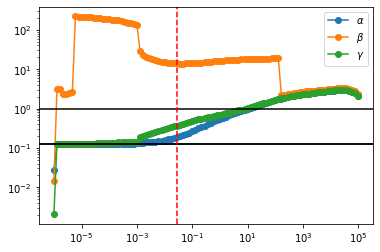

In [17]:
idx = 40
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], linestyle='--', color='r')
plt.legend()

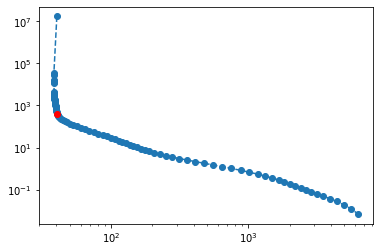

In [18]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

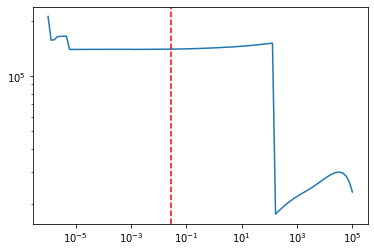

In [19]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], linestyle='--', color='r')

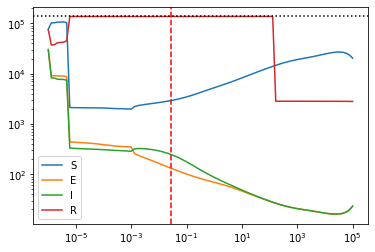

In [20]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIR")
plt.axhline(140000, color='k', linestyle=':')
plt.axvline(prange[idx], linestyle='--', color='r')

In [21]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

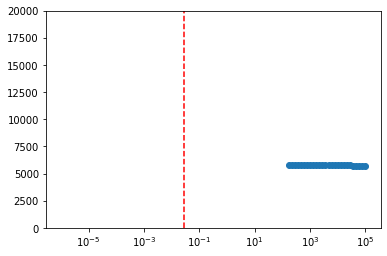

In [22]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], linestyle='--', color='r')
plt.ylim([0,20000])

In [23]:
def rfin_data(sol):
    sofx = sol['x']
    return getp(sofx)[2]*trapz(getx(sofx)[1].toarray().flatten(), model.observation_times)

Text(0, 0.5, 'Number of Cases')

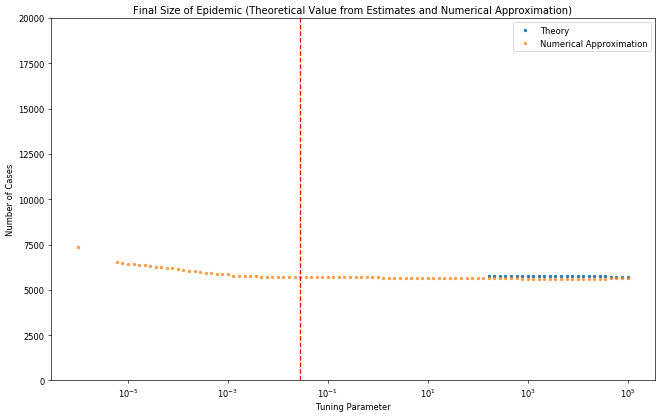

In [24]:
plt.figure(figsize=[13,8], dpi=60)
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], '.', label='Theory')
plt.semilogx(prange[:], [rfin_data(sol) for sol in sols][:], '.', label='Numerical Approximation', alpha=0.7)
plt.axvline(prange[idx], linestyle='--', color='r')
plt.ylim([0,20000])
plt.legend()
plt.title("Final Size of Epidemic (Theoretical Value from Estimates and Numerical Approximation)")
plt.xlabel("Tuning Parameter")
plt.ylabel("Number of Cases")

In [25]:
rfin_data(sols[idx])

DM(5711.2)

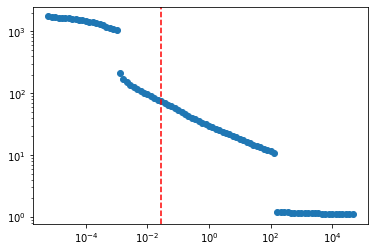

In [26]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], linestyle='--', color='r')

In [27]:
def r0theory(sol):
    S0, E0, I0, R0 = [float(xi[0]) for xi in getx(sol['x'])]
    Rinf = getx(sol['x'])[-1][-1]
    N = sum([S0, E0, I0, R0])
    return N/Rinf*np.log(S0/(N-Rinf))

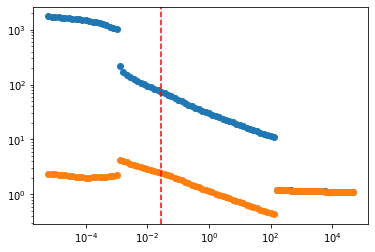

In [28]:
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.plot(prange[7:-3], [r0theory(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], linestyle='--', color='r')

In [29]:
[getx(sols[idx]['x'])[i][50] for i in range(4)]

[DM(4503.61), DM(294.348), DM(328.013), DM(135044)]

In [30]:
getx(sols[idx]['x'])[0][0]

DM(5905.49)

In [31]:
getp(sols[idx]['x'])

(DM(0.18854), DM(14.0107), DM(0.369642))

In [32]:
r0(sols[idx])

74.31169121599063

(0, 6000)

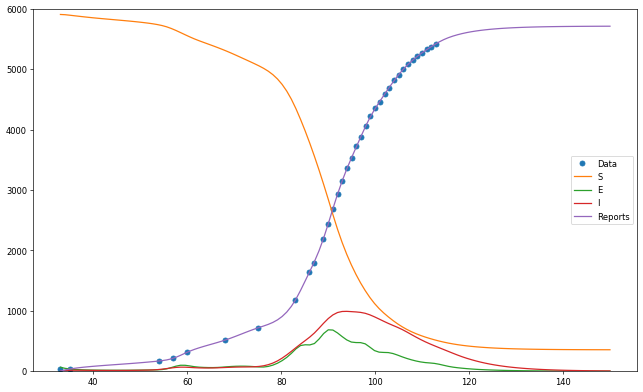

In [33]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
# ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
plt.plot(model.observation_times, 
         getp(sols[idx]['x'])[2]*cumtrapz(getx(sols[idx]['x'])[1].toarray().flatten(),
                                          model.observation_times, initial=0),
         label='Reports')
plt.legend()
plt.ylim([0, 6000])

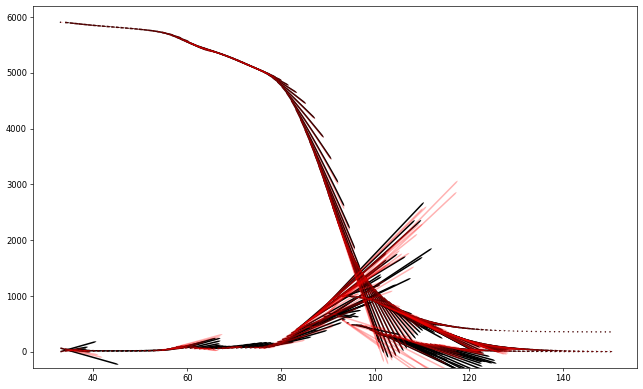

In [34]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx[:-1]):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx[:-1]):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Fit and Prediction)')

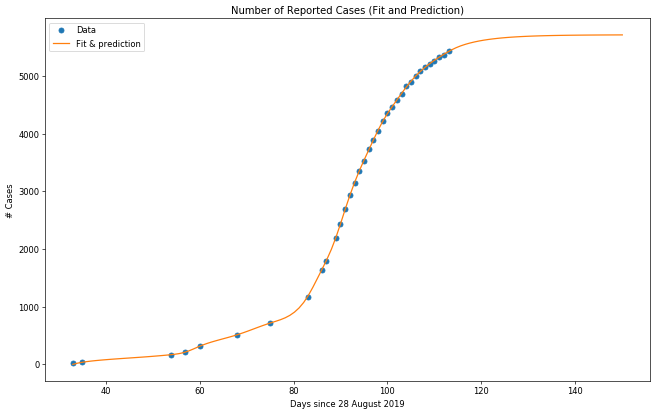

In [35]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
plt.plot(model.observation_times, 
         getp(sols[idx]['x'])[2]*cumtrapz(getx(sols[idx]['x'])[1].toarray().flatten(),
                                          model.observation_times, initial=0),
         label='Fit & prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Fit and Prediction)")

In [36]:
def idx_to_reports(idx):
     return getp(sols[idx]['x'])[2]*cumtrapz(getx(sols[idx]['x'])[1].toarray().flatten(),
                                             model.observation_times, initial=0)

(0, 10000)

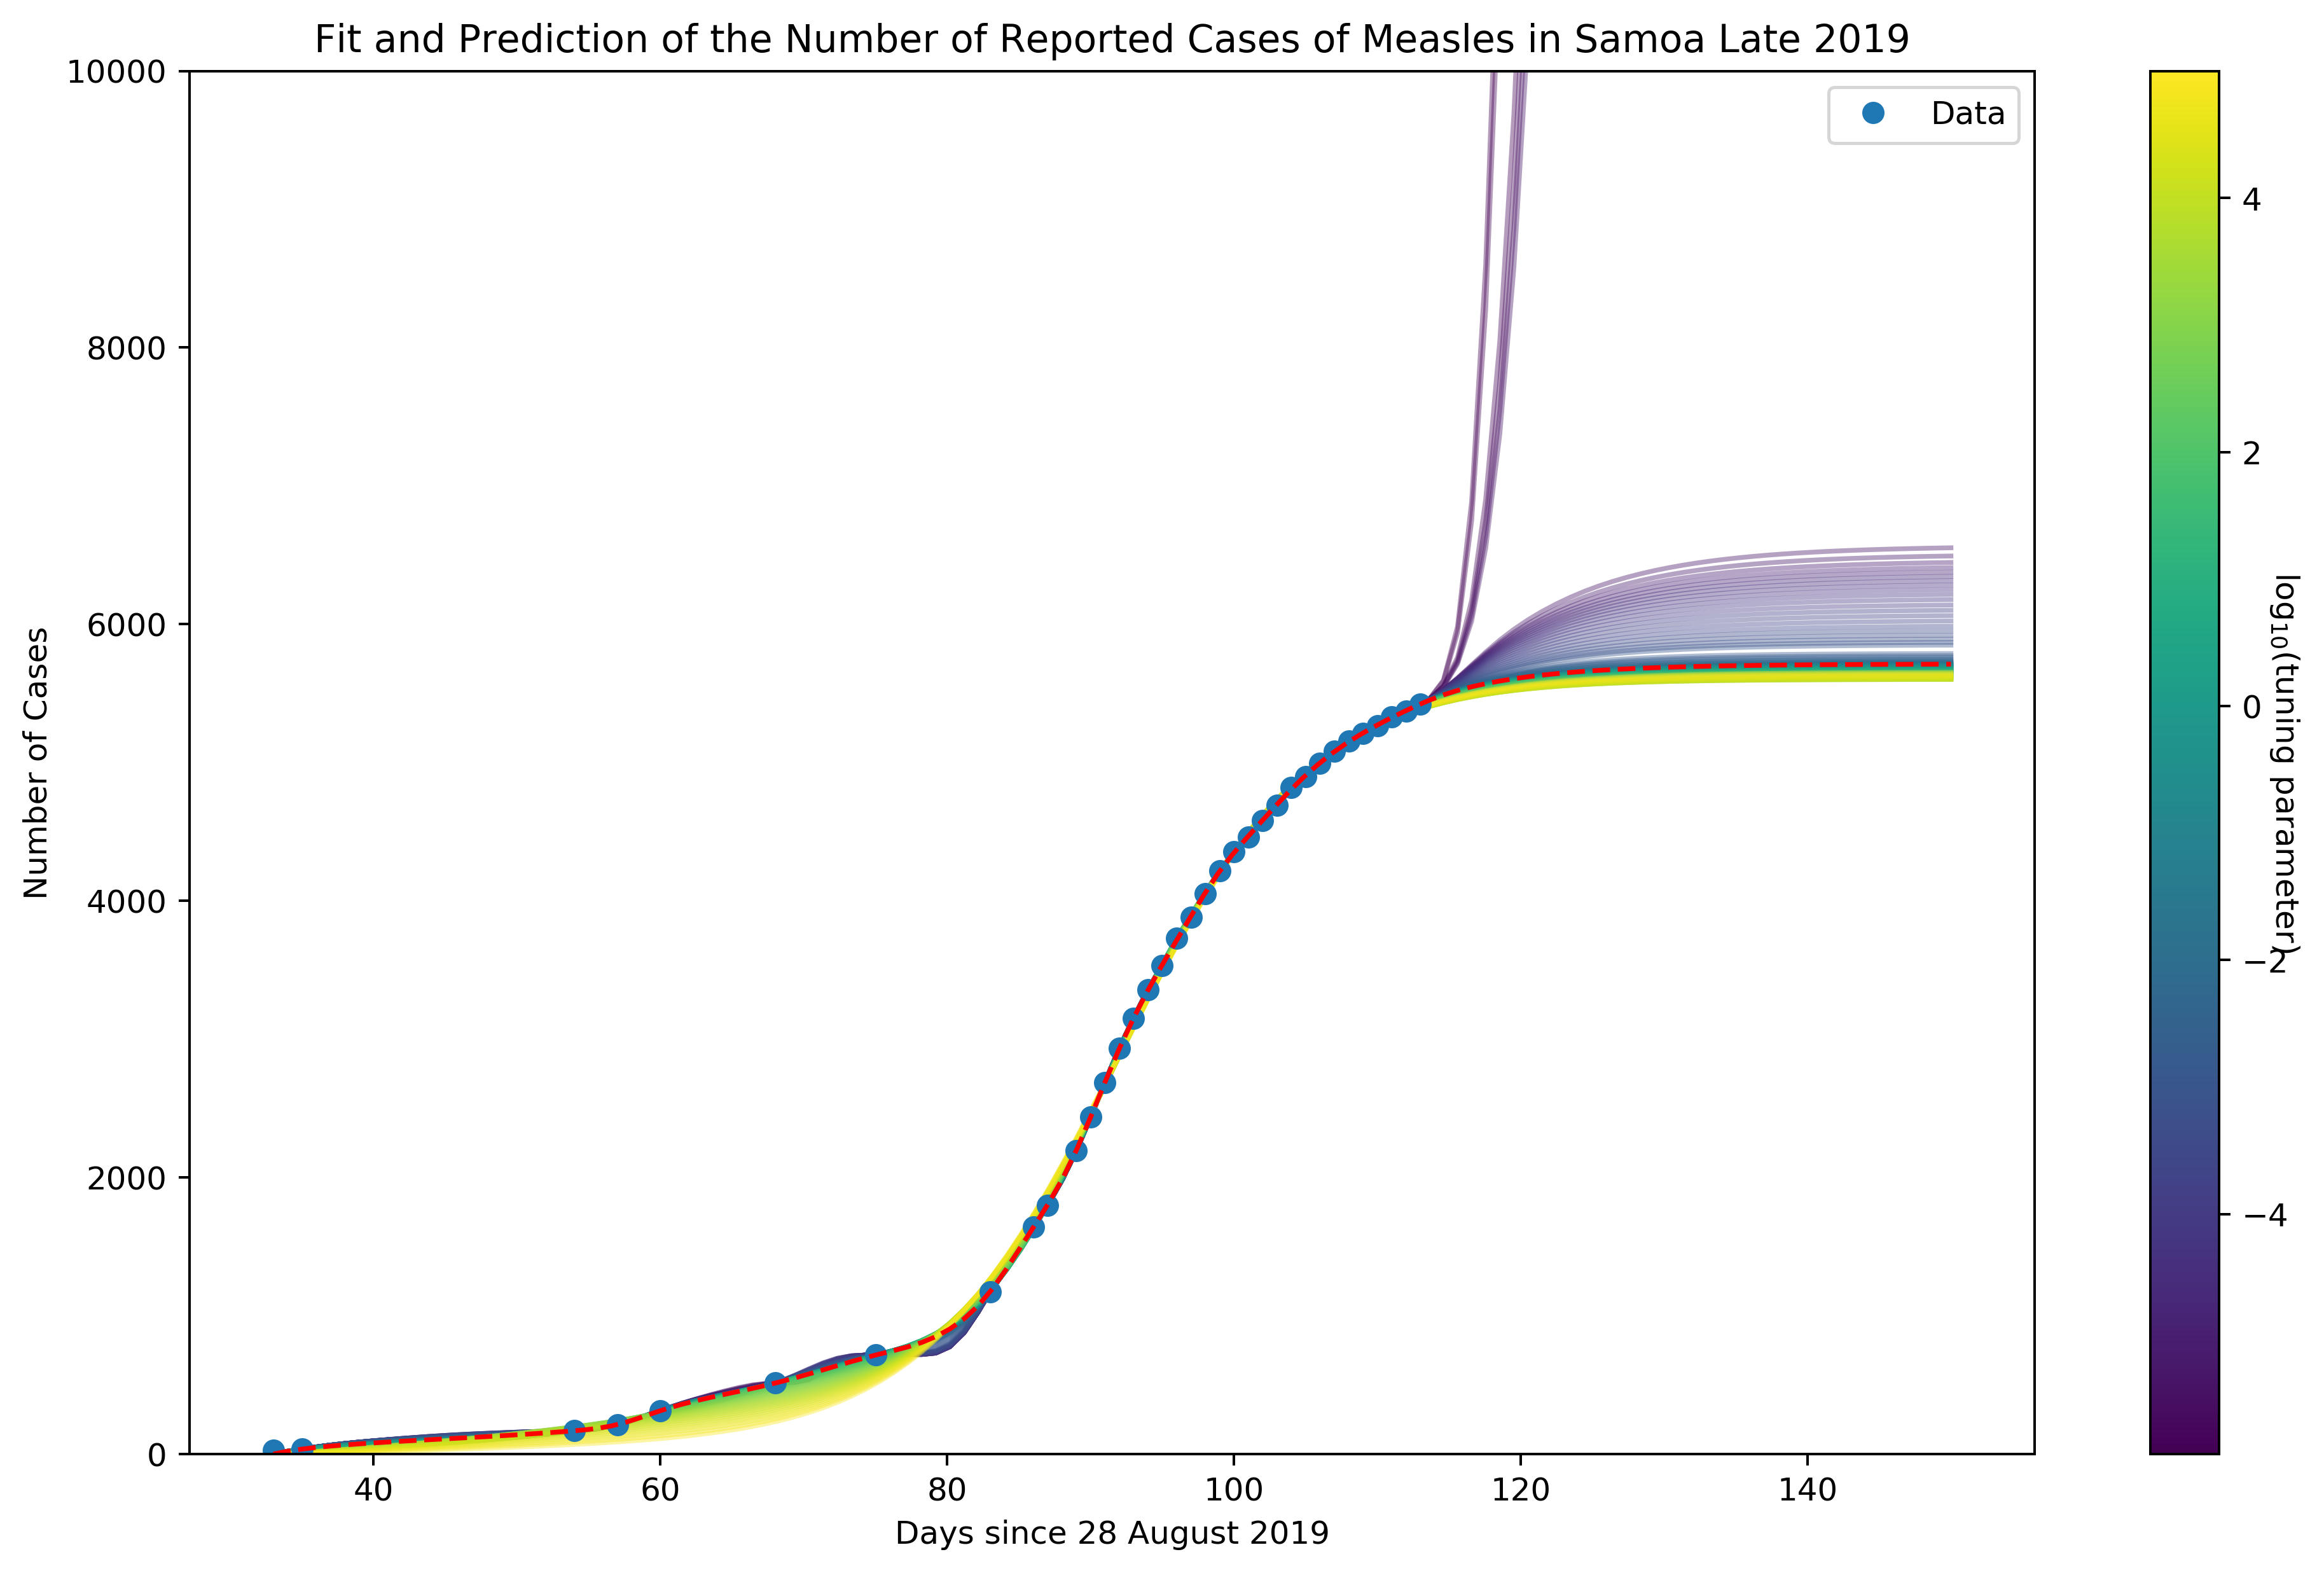

In [37]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, idx_to_reports(i+i0), color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
plt.plot(model.observation_times, idx_to_reports(idx), '--', color='r')
plt.ylim([0, 10000])

(0, 10000)

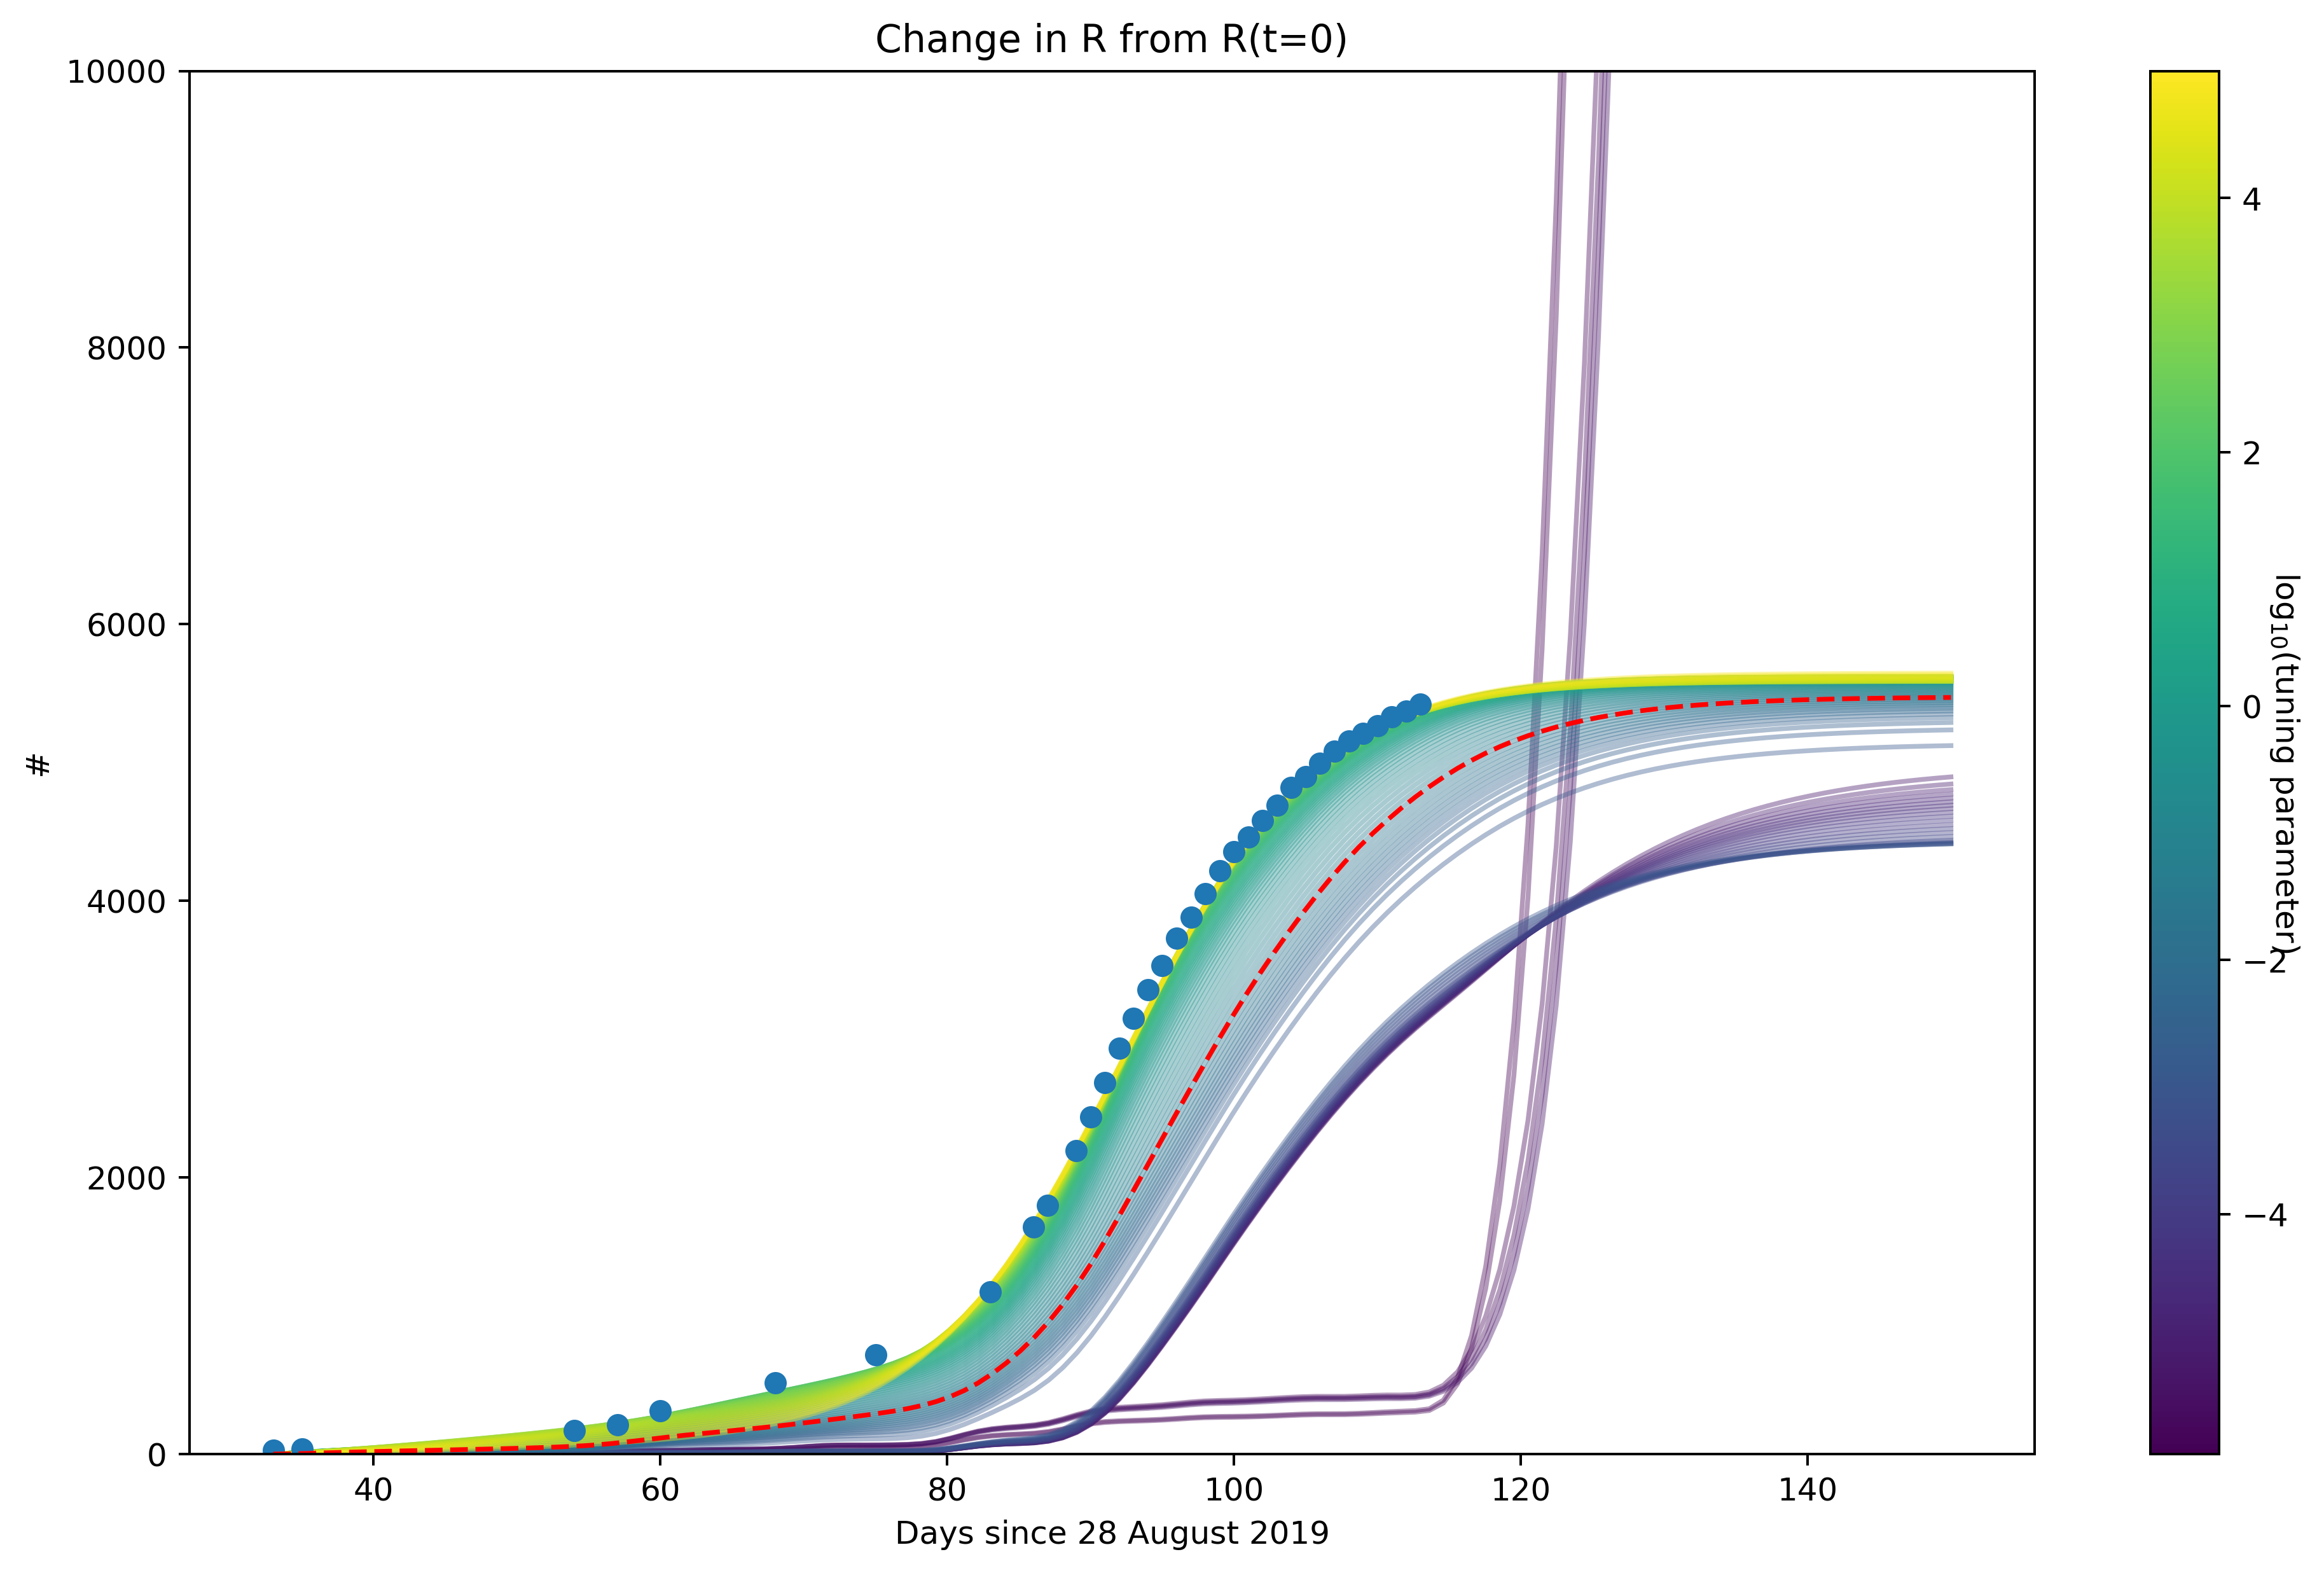

In [38]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-1] - getx(sols[i+i0]['x'])[-1][0], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.title("Change in R from R(t=0)")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("#")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.plot(times, cumdata, 'o', label="Data")
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1] - getx(sols[idx]['x'])[-1][0], '--', color='r')

plt.ylim(0, 10000)

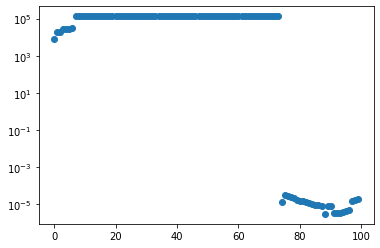

In [39]:
plt.semilogy([getx(sols[i]['x'])[-1][0] for i in range(len(prange))], 'o')

In [40]:
fsvals[idx]

array([ 40.52508049, 402.58389371])

(4000, 7000)

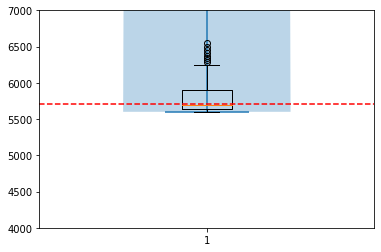

In [41]:
plt.violinplot([rfin_data(sol) for sol in sols])
plt.boxplot([rfin_data(sol) for sol in sols])
plt.axhline(float(rfin_data(sols[idx])), linestyle='--', color='r')
plt.ylim([4000, 7000])

In [42]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [ ]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), 
                                      p=[rho, alpha], lbx=lbx0, ubx=ubx0, lbg=0, ubg=140000))

In [ ]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

In [ ]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(pvals, f0)

In [ ]:
list(zip(range(50), pvals,f0r))

In [ ]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

In [ ]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(pvals, f1)

In [ ]:
list(zip(range(50), pvals,f1r))

In [ ]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [ ]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

In [ ]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [ ]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

In [ ]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(pvals, f2)
plt.axvline(float(pref[2]), color='k')

In [ ]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [ ]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(4)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

In [ ]:
[getx(sols[idx]['x'])[i][tidx] for i in range(4)]

In [ ]:
plt.plot(sol.t, sol.y[:,:].T)

In [ ]:
model.observation_times[-1]

In [ ]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx],  750+getp(sols[idx]['x'])[2]*cumtrapz(sol.sol(tfine)[1,:], tfine, initial=0),)
plt.plot(times, cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")


In [ ]:
rfin = sol.sol(tfine)[-1,-1] - sol.sol(tfine)[-1, 0]
rfin

In [ ]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [ ]:
tfine[ridx]

In [ ]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

In [ ]:
model.observation_times[-1]-model.observation_times[tidx]

In [ ]:
historical_mortality = 0.02
current_mortality = D[-1]/cumdata[-1]
print(historical_mortality, current_mortality)

In [ ]:
rfin*historical_mortality

In [ ]:
rfin*current_mortality

In [ ]:
[rfin_data(sols[idx])*mor for mor in [historical_mortality, current_mortality]]

In [ ]:
raise KeyboardInterrupt
prangeb = np.logspace(-6, 6, num=100)[idx:0:-1]
solsb = []
xguessb = sols[idx]['x'].toarray().flatten()
for p in prangeb:
    solve_opts = {
        'x0': xguessb,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    solsb.append(solver(**solve_opts))
    xguessb = np.array(solsb[-1]['x']).flatten()

In [ ]:
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prangeb, [float(s['x'][-3]) for s in solsb], 'o-', label=r'$b\alpha$')
plt.plot(prangeb, [float(s['x'][-2]) for s in solsb], 'o-', label=r'$b\beta$')
plt.plot(prangeb, [float(s['x'][-1]) for s in solsb], 'o-', label=r'$b\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.legend()